# Problem Statement



***Context and Importance:***

The wine industry is a multi-billion dollar global market, where both connoisseurs and casual drinkers rely heavily on wine reviews to make informed purchasing decisions. These reviews often encompass various aspects such as the wine's country of origin, variety, price, and tasting notes. Understanding the patterns and factors that influence wine ratings and prices can provide valuable insights for producers, retailers, and consumers alike.

***Objective:***

This analysis aims to explore and analyze a dataset of wine reviews to uncover key patterns and trends. Specifically, the objectives are to:

Identify the main factors influencing wine ratings and prices.
Examine the differences in wine characteristics across different countries and varieties.
Predict wine ratings based on available features using regression models.

***Research Questions:***

What are the primary factors that affect the price of wine?
Is there a significant difference in the average price of red wines compared to white wines?
How do wine ratings differ across different countries and varieties?

***Scope:***

The analysis will include data cleaning and preprocessing steps to prepare the dataset for in-depth analysis. It will employ descriptive statistics, visualizations, hypothesis testing, confidence intervals, and regression analysis to address the research questions. The focus will be on the dataset available from Kaggle, which includes detailed wine reviews.

In [214]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import ttest_ind
import plotly.express as px
import warnings
warnings.filterwarnings("ignore")

# Description of the dataset

**Source of dataset:** https://www.kaggle.com/datasets/zynicide/wine-reviews

**Number of observations**: The dataset contains 130,000 wine reviews.

**Number of variables per observation**: Each observation includes 14 variables.



In [215]:
df = pd.read_csv('winemag-data-130k-v2.csv')
df.sample(5)

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
27591,27591,France,This is a major wine from a great white wine v...,NaN,98,367.0,Burgundy,Bâtard-Montrachet,NaN,Roger Voss,@vossroger,Louis Jadot 2014 Bâtard-Montrachet,Chardonnay,Louis Jadot
114652,114652,US,"Bright in acidity, it's light in texture, soft...",Los Tesoros,88,55.0,California,Livermore Valley,Central Coast,Virginie Boone,@vboone,Murrieta's Well 2011 Los Tesoros Touriga Nacio...,Touriga Nacional,Murrieta's Well
78782,78782,France,This pure Merlot wine from Mayne-Vieil is ripe...,Cuvée Aliénor,92,24.0,Bordeaux,Fronsac,NaN,Roger Voss,@vossroger,Château Mayne Vieil 2014 Cuvée Aliénor (Fronsac),Merlot,Château Mayne Vieil
96861,96861,Italy,Siro Pacenti is among a handful of producers w...,Pelagrilli,91,60.0,Tuscany,Brunello di Montalcino,NaN,NaN,NaN,Siro Pacenti 2008 Pelagrilli (Brunello di Mon...,Sangiovese Grosso,Siro Pacenti
19194,19194,Chile,Some years Calina makes Bravura and in others ...,Bravura,91,45.0,Colchagua Valley,NaN,NaN,Michael Schachner,@wineschach,Calina 2003 Bravura Red (Colchagua Valley),Cabernet Blend,Calina


**Meaning and type of the different variables**

In [216]:
df.dtypes

Unnamed: 0                 int64
country                   object
description               object
designation               object
points                     int64
price                    float64
province                  object
region_1                  object
region_2                  object
taster_name               object
taster_twitter_handle     object
title                     object
variety                   object
winery                    object
dtype: object

# Data Cleaning

The column ‘Unnamed: 0’ is not needed as it is the line number and we already have that.

We find that the columns ‘taster_name’ and ‘taster_twitter_handle’ are also not useful for our project.

We proceed to delete these columns from the dataframe:

In [217]:
df.drop(columns=['Unnamed: 0', 'taster_name', 'taster_twitter_handle'], inplace=True)

### Drop duplicates

as first we check for duplicates and delete them

In [218]:
duplicated = df.duplicated().sum()
print(f"Total duplicate: {duplicated}")
df.drop_duplicates(inplace=True)
duplicated = df.duplicated().sum()
print(f"Total duplicate: {duplicated}")

Total duplicate: 9983
Total duplicate: 0


### Data Quality Assessment

Display of missing values, unique values and duplicates of each column

In [219]:
# Initialize a list to store the data
data_quality = []

# Calculate the metrics for each column and store them in the list
for column in df.columns:
    nan_count = df[column].isna().sum()
    unique_count = df[column].nunique()
    total_entries = df.shape[0]
    duplicates = total_entries - unique_count - nan_count
    
    data_quality.append({
        'Column': column,
        'Missing Values': nan_count,
        'Unique Values': unique_count,
        'Duplicates': duplicates
    })

# Create a DataFrame from the list
data_quality_df = pd.DataFrame(data_quality)

data_quality_df

,Column,Missing Values,Unique Values,Duplicates
0,country,59,43,119886
1,description,0,119955,33
2,designation,34545,37979,47464
3,points,0,21,119967
4,price,8395,390,111203
5,province,59,425,119504
6,region_1,19560,1229,99199
7,region_2,73219,17,46752
8,title,0,118840,1148
9,variety,1,707,119280


the columns that need to be arranged are ‘country’, ‘designation’, ‘price’, ‘province’, 'region_1', “region_2” and “variety”.

I also have to check ‘description’ as it should be unique for each wine

### Country column analysis

Filtering the DataFrame to show only rows where 'country' has NaN values

In [220]:
# Filter the DataFrame to show only rows where 'country' has NaN values
rows_with_nan = df[df['country'].isna()]
rows_with_nan.head(10)

,country,description,designation,points,price,province,region_1,region_2,title,variety,winery
913,NaN,"Amber in color, this wine has aromas of peach ...",Asureti Valley,87,30.0,NaN,NaN,NaN,Gotsa Family Wines 2014 Asureti Valley Chinuri,Chinuri,Gotsa Family Wines
3131,NaN,"Soft, fruity and juicy, this is a pleasant, si...",Partager,83,NaN,NaN,NaN,NaN,Barton & Guestier NV Partager Red,Red Blend,Barton & Guestier
4243,NaN,"Violet-red in color, this semisweet wine has a...",Red Naturally Semi-Sweet,88,18.0,NaN,NaN,NaN,Kakhetia Traditional Winemaking 2012 Red Natur...,Ojaleshi,Kakhetia Traditional Winemaking
9509,NaN,This mouthwatering blend starts with a nose of...,Theopetra Malagouzia-Assyrtiko,92,28.0,NaN,NaN,NaN,Tsililis 2015 Theopetra Malagouzia-Assyrtiko W...,White Blend,Tsililis
9750,NaN,This orange-style wine has a cloudy yellow-gol...,Orange Nikolaevo Vineyard,89,28.0,NaN,NaN,NaN,Ross-idi 2015 Orange Nikolaevo Vineyard Chardo...,Chardonnay,Ross-idi
11150,NaN,"A blend of 85% Melnik, 10% Grenache Noir and 5...",NaN,89,20.0,NaN,NaN,NaN,Orbelus 2013 Melnik,Melnik,Orbelus
11348,NaN,"Light and fruity, this is a wine that has some...",Partager,82,NaN,NaN,NaN,NaN,Barton & Guestier NV Partager White,White Blend,Barton & Guestier
14030,NaN,"This Furmint, grown in marl soils, has aromas ...",Márga,88,25.0,NaN,NaN,NaN,St. Donat 2013 Márga White,White Blend,St. Donat
16000,NaN,"Jumpy, jammy aromas of foxy black fruits are s...",Valle de los Manantiales Vineyard,86,40.0,NaN,NaN,NaN,Familia Deicas 2015 Valle de los Manantiales V...,Tannat,Familia Deicas
16749,NaN,Winemaker: Bartho Eksteen. This wooded Sauvy s...,Cape Winemakers Guild Vloekskoot Wooded,91,NaN,NaN,NaN,NaN,Bartho Eksteen 2016 Cape Winemakers Guild Vloe...,Sauvignon Blanc,Bartho Eksteen


59 lines are missing the country, province and region, so we have no idea where the wine comes from.

As these are 59 lines out of 111538, we decide to delete them.

In [221]:
df = df.dropna(subset=["country"])

### Description column analysis

Above we can see that the column "description" has 33 duplicate, a description is something unique, we must investigate

now i will display some duplicate wine to understand better

In [222]:
# Check for duplicates in the 'description' column
duplicate_descriptions = df[df.duplicated(subset='description', keep=False)]

# Display the duplicate 
#duplicate_descriptions_full = duplicate_descriptions
#duplicate_descriptions_full

duplicate_example = duplicate_descriptions[duplicate_descriptions['description'] == duplicate_descriptions.iloc[0]['description']]
duplicate_example_full = duplicate_example.head(5)

duplicate_example_full

,country,description,designation,points,price,province,region_1,region_2,title,variety,winery
2159,Italy,"Easygoing and enjoyable, this has aromas of ma...",NaN,84,15.0,Central Italy,Montepulciano d'Abruzzo,NaN,Valori 2014 Montepulciano d'Abruzzo,Montepulciano,Valori
22963,Italy,"Easygoing and enjoyable, this has aromas of ma...",NaN,86,NaN,Central Italy,Montepulciano d'Abruzzo,NaN,Quattro Mani 2015 Montepulciano d'Abruzzo,Montepulciano,Quattro Mani


in this case we can see that all columns have the same values.

we show several rows to see if this is the case for all duplicates

In [223]:
sorted_duplicates = duplicate_descriptions.sort_values(by='description')
sorted_duplicates

,country,description,designation,points,price,province,region_1,region_2,title,variety,winery
71853,France,90–92. Barrel sample. This is a solid and dens...,Barrel Sample,91,NaN,Bordeaux,Moulis-en-Médoc,NaN,Château Maucaillou 2012 Barrel Sample (Moulis...,Bordeaux-style Red Blend,Château Maucaillou
71851,France,90–92. Barrel sample. This is a solid and dens...,Barrel Sample,91,NaN,Bordeaux,Margaux,NaN,Château Pontac-Lynch 2012 Barrel Sample (Marg...,Bordeaux-style Red Blend,Château Pontac-Lynch
105559,France,92–94. Barrel sample. With so much spicy fruit...,Barrel Sample,93,NaN,Bordeaux,Saint-Julien,NaN,Château Gruaud Larose 2012 Barrel Sample (Sai...,Bordeaux-style Red Blend,Château Gruaud Larose
105554,France,92–94. Barrel sample. With so much spicy fruit...,Barrel Sample,93,NaN,Bordeaux,Pauillac,NaN,Château Grand-Puy-Lacoste 2012 Barrel Sample ...,Bordeaux-style Red Blend,Château Grand-Puy-Lacoste
73905,Italy,"Almost too much of a good thing, Passo is a th...",Passo,88,35.0,Veneto,Rosso del Veronese,NaN,Stefano Accordini 2007 Passo Red (Rosso del Ve...,Red Blend,Stefano Accordini
...,...,...,...,...,...,...,...,...,...,...,...
19269,Italy,This zesty red has pretty aromas that suggest ...,NaN,87,30.0,Tuscany,Rosso di Montalcino,NaN,Carpineto 2014 Rosso di Montalcino,Sangiovese,Carpineto
83693,US,Very ripe and forward in baked fruit or pie-fi...,NaN,84,45.0,California,Santa Ynez Valley,Central Coast,Sunstone 2006 Syrah (Santa Ynez Valley),Syrah,Sunstone
61484,US,Very ripe and forward in baked fruit or pie-fi...,Reserve,85,48.0,California,Santa Ynez Valley,Central Coast,Sunstone 2006 Reserve Syrah (Santa Ynez Valley),Syrah,Sunstone
31584,Italy,"Vibrant and spicy, this savory red delivers ar...",Costera,90,18.0,Sicily & Sardinia,Cannonau di Sardegna,NaN,Argiolas 2013 Costera (Cannonau di Sardegna),Red Blend,Argiolas


You can see that in these wines, although the description is the same, there are columns with different values, so they are not duplicates

### Handle NaN

***Columns with string data type***

We want to replace NaN value with 0 in the Price column

In [224]:
rows_with_nan = df[df['variety'].isna()]
rows_with_nan

,country,description,designation,points,price,province,region_1,region_2,title,variety,winery
86909,Chile,"A chalky, dusty mouthfeel nicely balances this...",NaN,88,17.0,Maipo Valley,NaN,NaN,Carmen 1999 (Maipo Valley),NaN,Carmen


In [225]:

df['variety'].fillna('Not-Available', inplace=True)

In [226]:
# Define the columns you want to check and replace NaN values
columns_to_check = ['designation', 'province', 'region_1', 'region_2', 'variety']

# Iterate over each column and replace NaN values with 'Not-available'
for column in columns_to_check:
    # Find the index of the row with NaN in the current column
    row_with_nan_index = df[df[column].isna()].index

    # Assign 'Not-available' to that row and column
    df.loc[row_with_nan_index, column] = 'Not-available'

***Price column***


It makes no sense to replace NaN in the price with 0, because in most statistics we would discard these rows. So we decide to delete these 8391 rows

In [227]:
nan_count = df['price'].isna().sum()
print("Before:")
print(f"total NaN in price: {nan_count}")

#df['price'] = df['price'].fillna(0).astype('float64')
df = df.dropna(subset=['price'])

nan_count = df['price'].isna().sum()
print("After:")
print(f"total NaN in price: {nan_count}")

Before:
total NaN in price: 8391
After:
total NaN in price: 0


### Level of noise in price

In this section, we aim to identify the level of noise within our dataset by detecting outliers in the price column. Outliers are extreme values that deviate significantly from the rest of the data and can potentially skew the analysis. By flagging these outliers, we can better understand the variability and quality of our data.

In [228]:
# Using IQR to identify outliers in the 'price' column
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Flagging the outliers without removing them
df['is_outlier'] = (df['price'] < lower_bound) | (df['price'] > upper_bound)
outliers_df = df[df['is_outlier'] == True]

num_outliers = df['is_outlier'].sum()
total_observations = df.shape[0]

# Proportion of outliers
proportion_outliers = num_outliers / total_observations

print(f"Number of outlier wines: {num_outliers}")
print(f"Total number of observations: {total_observations}")
print(f"Proportion of outliers: {proportion_outliers:.2%}")



Number of outlier wines: 6869
Total number of observations: 111538
Proportion of outliers: 6.16%


# Preprocessing

with this dataset is interesting create new columns, like price category and wine vintage

## Price Category column


at first we plot the histogram of the price to have a global idea

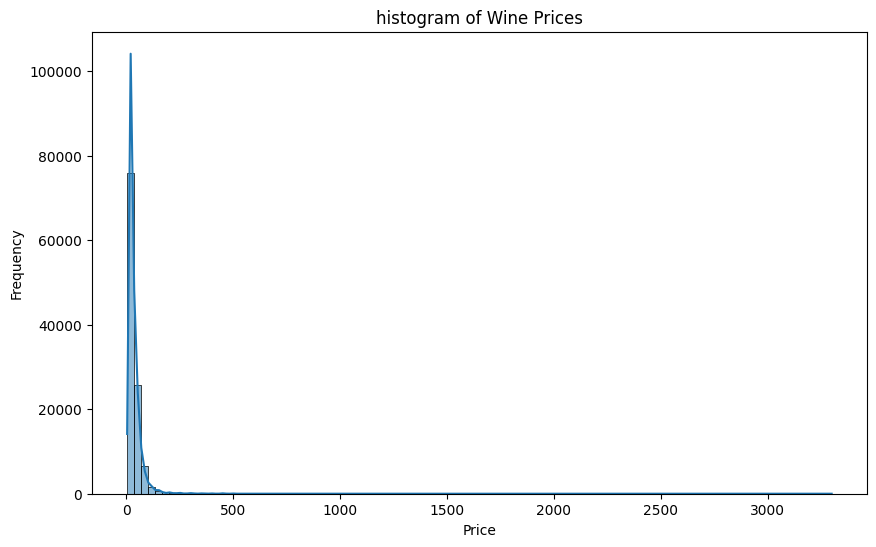

In [229]:
# Create a filtered DataFrame excluding rows where 'price' is 0 for the histogram
df_non_zero_price = df[df['price'] > 0]
df = df_non_zero_price

plt.figure(figsize=(10, 6))
sns.histplot(df['price'], bins=100, kde=True)
plt.title('histogram of Wine Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()



As we can see, the plot of the price is left-skewed, and we could also observe it by catecorize the wines in a price category.

To analyze the distribution of wines across different price ranges, we categorize prices into 'Low', 'Medium', and 'High' categories

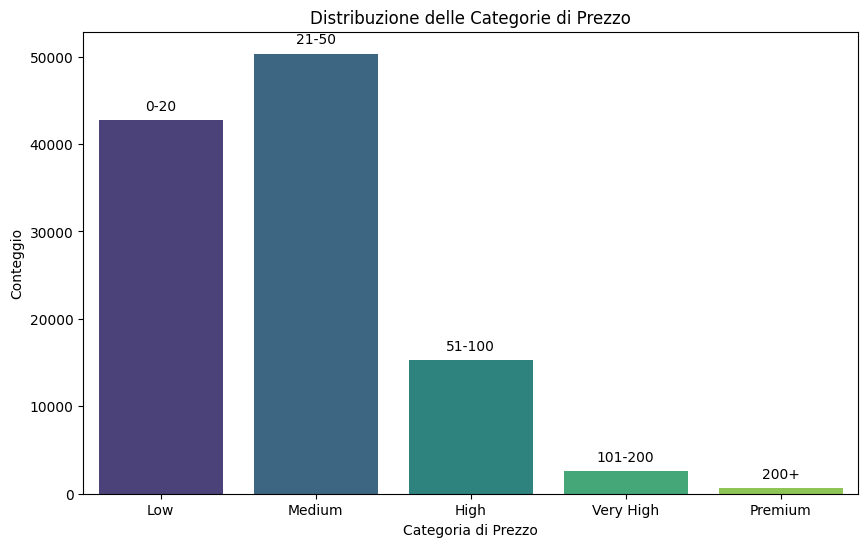

In [230]:
bins = [0, 20, 50, 100, 200, np.inf]
labels = ['Low', 'Medium', 'High', 'Very High', 'Premium']
df['price_category'] = pd.cut(df['price'], bins=bins, labels=labels)

# Plotting with seaborn
plt.figure(figsize=(10, 6))
palette = sns.color_palette("viridis", len(labels)) # Create a palette with a color for each category
ax = sns.countplot(data=df, x='price_category', palette=palette)
plt.title('Distribuzione delle Categorie di Prezzo')
plt.xlabel('Categoria di Prezzo')
plt.ylabel('Conteggio')

# Annotate bars with price range
price_ranges = ['0-20', '21-50', '51-100', '101-200', '200+']
for p, label, price_range in zip(ax.patches, labels, price_ranges):
    ax.annotate(f'{price_range}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()

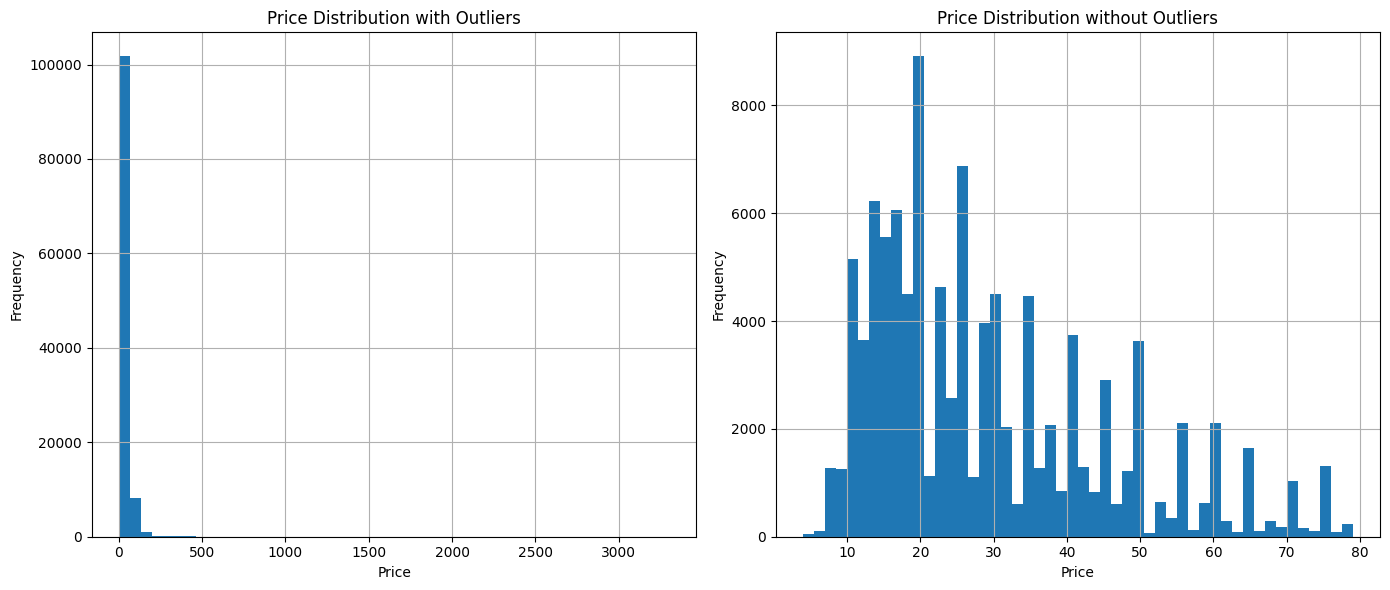

In [231]:
# Create a boolean mask for non-outliers
non_outliers_mask = df['is_outlier'] == False
df_without_outliers = df[non_outliers_mask]

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
df['price'].hist(bins=50)
plt.title('Price Distribution with Outliers')
plt.xlabel('Price')
plt.ylabel('Frequency')

# Histogram of prices without outliers
plt.subplot(1, 2, 2)
df_without_outliers['price'].hist(bins=50)
plt.title('Price Distribution without Outliers')
plt.xlabel('Price')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

## Wine Vintage column

In [232]:
import re
# Function to extract the vintage year from the title or description
def extract_vintage(row):
    # Try to find the year in the title first
    title_match = re.search(r'\b(19|20)\d{2}\b', row['title'])
    if title_match:
        return int(title_match.group(0))
    # If not found in title, try to find the year in the description
    description_match = re.search(r'\b(19|20)\d{2}\b', row['description'])
    if description_match:
        return int(description_match.group(0))
    # If not found in either, return None
    return None

# Apply the function to the dataframe to create the vintage column
df['vintage'] = df.apply(extract_vintage, axis=1)

nan_counts = df.isna().sum()
nan_counts
print("Number of NaN: ", nan_count)

# Converting the vintage column to integer type to remove the .0
df['vintage'] = df['vintage'].astype('Int64')

#new column check
df[['title', 'description', 'vintage']].head()


Number of NaN:  0


,title,description,vintage
1,Quinta dos Avidagos 2011 Avidagos Red (Douro),"This is ripe and fruity, a wine that is smooth...",2011
2,Rainstorm 2013 Pinot Gris (Willamette Valley),"Tart and snappy, the flavors of lime flesh and...",2013
3,St. Julian 2013 Reserve Late Harvest Riesling ...,"Pineapple rind, lemon pith and orange blossom ...",2013
4,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,"Much like the regular bottling from 2012, this...",2012
5,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Blackberry and raspberry aromas show a typical...,2011


In [233]:
df

,country,description,designation,points,price,province,region_1,region_2,title,variety,winery,is_outlier,price_category,vintage
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,Not-available,Not-available,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,False,Low,2011
2,US,"Tart and snappy, the flavors of lime flesh and...",Not-available,87,14.0,Oregon,Willamette Valley,Willamette Valley,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,False,Low,2013
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,Not-available,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,False,Low,2013
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,False,High,2012
5,Spain,Blackberry and raspberry aromas show a typical...,Ars In Vitro,87,15.0,Northern Spain,Navarra,Not-available,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem,False,Low,2011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129966,Germany,Notes of honeysuckle and cantaloupe sweeten th...,Brauneberger Juffer-Sonnenuhr Spätlese,90,28.0,Mosel,Not-available,Not-available,Dr. H. Thanisch (Erben Müller-Burggraef) 2013 ...,Riesling,Dr. H. Thanisch (Erben Müller-Burggraef),False,Medium,2013
129967,US,Citation is given as much as a decade of bottl...,Not-available,90,75.0,Oregon,Oregon,Oregon Other,Citation 2004 Pinot Noir (Oregon),Pinot Noir,Citation,False,High,2004
129968,France,Well-drained gravel soil gives this wine its c...,Kritt,90,30.0,Alsace,Alsace,Not-available,Domaine Gresser 2013 Kritt Gewurztraminer (Als...,Gewürztraminer,Domaine Gresser,False,Medium,2013
129969,France,"A dry style of Pinot Gris, this is crisp with ...",Not-available,90,32.0,Alsace,Alsace,Not-available,Domaine Marcel Deiss 2012 Pinot Gris (Alsace),Pinot Gris,Domaine Marcel Deiss,False,Medium,2012


## description length column

The length of the wine description might correlate with the wine rating, so we create a new variable to capture this information.

In [234]:
df['review_length'] = df['description'].apply(lambda x: len(x) if pd.notnull(x) else 0)

# Verifica che la colonna sia stata aggiunta correttamente
df.head(10)

,country,description,designation,points,price,province,region_1,region_2,title,variety,winery,is_outlier,price_category,vintage,review_length
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,Not-available,Not-available,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,False,Low,2011,227
2,US,"Tart and snappy, the flavors of lime flesh and...",Not-available,87,14.0,Oregon,Willamette Valley,Willamette Valley,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,False,Low,2013,186
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,Not-available,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,False,Low,2013,199
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,False,High,2012,249
5,Spain,Blackberry and raspberry aromas show a typical...,Ars In Vitro,87,15.0,Northern Spain,Navarra,Not-available,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem,False,Low,2011,261
6,Italy,"Here's a bright, informal red that opens with ...",Belsito,87,16.0,Sicily & Sardinia,Vittoria,Not-available,Terre di Giurfo 2013 Belsito Frappato (Vittoria),Frappato,Terre di Giurfo,False,Low,2013,181
7,France,This dry and restrained wine offers spice in p...,Not-available,87,24.0,Alsace,Alsace,Not-available,Trimbach 2012 Gewurztraminer (Alsace),Gewürztraminer,Trimbach,False,Medium,2012,122
8,Germany,Savory dried thyme notes accent sunnier flavor...,Shine,87,12.0,Rheinhessen,Not-available,Not-available,Heinz Eifel 2013 Shine Gewürztraminer (Rheinhe...,Gewürztraminer,Heinz Eifel,False,Low,2013,156
9,France,This has great depth of flavor with its fresh ...,Les Natures,87,27.0,Alsace,Alsace,Not-available,Jean-Baptiste Adam 2012 Les Natures Pinot Gris...,Pinot Gris,Jean-Baptiste Adam,False,Medium,2012,160
10,US,"Soft, supple plum envelopes an oaky structure ...",Mountain Cuvée,87,19.0,California,Napa Valley,Napa,Kirkland Signature 2011 Mountain Cuvée Caberne...,Cabernet Sauvignon,Kirkland Signature,False,Low,2011,243


# Data Exploration

### Analysis and visualisation of our data 

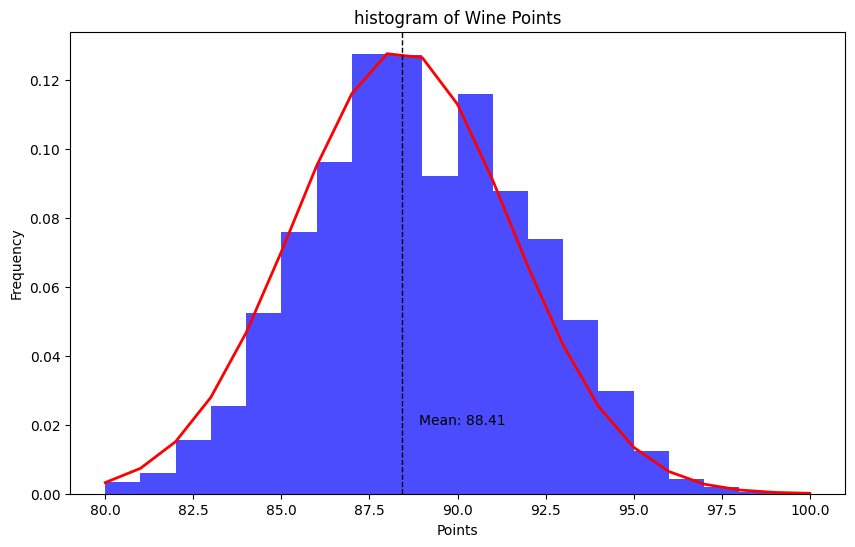

In [235]:
# Histogram of Wine Points
# Assuming 'points' is your column of interest
mean_points = df['points'].mean()
std_points = df['points'].std()

# Generate values for the normal distribution curve
normal_dist = stats.norm.pdf(sorted(df['points']), mean_points, std_points)

plt.figure(figsize=(10, 6))
plt.hist(df['points'], bins=20, density=True, color='blue', alpha=0.7)
plt.plot(sorted(df['points']), normal_dist, color='red', linewidth=2)
plt.title('histogram of Wine Points')
plt.xlabel('Points')
plt.ylabel('Frequency')
plt.axvline(mean_points, color='k', linestyle='dashed', linewidth=1)
plt.text(mean_points + 0.5, 0.02, f'Mean: {mean_points:.2f}', rotation=0)
plt.show()

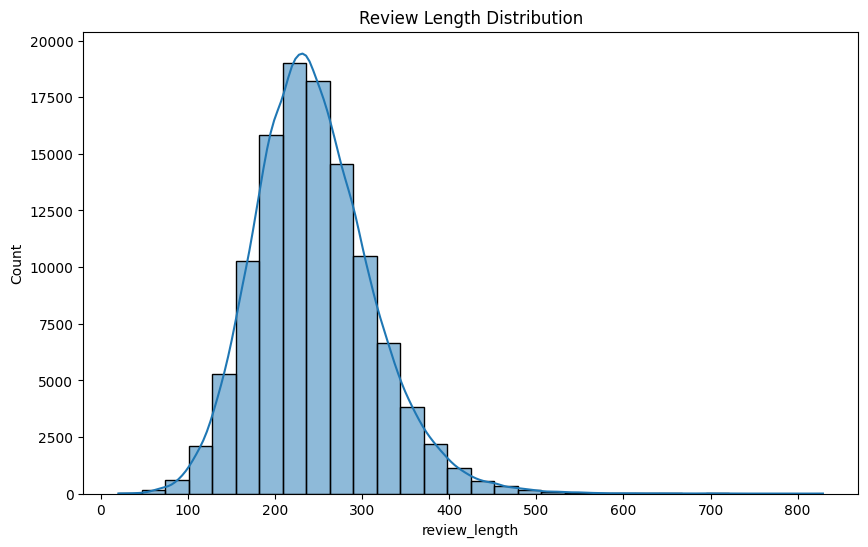

In [236]:
df['review_length'] = df['description'].apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(df['review_length'], bins=30, kde=True)
plt.title('Review Length Distribution')
plt.show()

In [237]:
df['vintage'] = pd.to_numeric(df['vintage'], errors='coerce')

# Conta il numero di vini per paese e per anno
country_vintage_counts = df.groupby(['country', 'vintage']).size().reset_index(name='count')

# Ordina il dataframe per 'vintage' e 'country'
country_vintage_counts = country_vintage_counts.sort_values(by=['vintage', 'country'])

# Calcola il conteggio cumulativo dei vini per ciascun paese
country_vintage_counts['cumulative_count'] = country_vintage_counts.groupby('country')['count'].cumsum()

# Creazione di un intervallo di anni completo per ciascun paese
all_years = pd.DataFrame({'vintage': range(country_vintage_counts['vintage'].min(), country_vintage_counts['vintage'].max() + 1)})
country_list = country_vintage_counts['country'].unique()

# Unire i dati originali con l'intervallo di anni completo
full_data = pd.DataFrame()
for country in country_list:
    country_data = country_vintage_counts[country_vintage_counts['country'] == country]
    country_data = all_years.merge(country_data, on='vintage', how='left')
    country_data['country'] = country
    country_data['cumulative_count'] = country_data['cumulative_count'].fillna(method='ffill').fillna(0)
    full_data = pd.concat([full_data, country_data], ignore_index=True)

# Genera la mappa del mondo animata con conteggio cumulativo
fig = px.choropleth(full_data,
                    locations="country",
                    locationmode='country names',
                    color="cumulative_count",
                    hover_name="country",
                    animation_frame="vintage",
                    color_continuous_scale=px.colors.sequential.Plasma,
                    title="World Wine Distribution Over Time (Cumulative)")
fig.update_layout(width=1200, height=600)
fig.show()

In [238]:
us_wine_data = df[df['country'] == 'US']

us_wine_data = df[df['country'] == 'US']

# Contare il numero di vini per stato (provincia)
state_wine_counts = us_wine_data['province'].value_counts().reset_index()
state_wine_counts.columns = ['province', 'count']

# Lista degli stati USA corretta
state_abbreviations = {
    'Alabama': 'AL', 'Alaska': 'AK', 'Arizona': 'AZ', 'Arkansas': 'AR', 'California': 'CA',
    'Colorado': 'CO', 'Connecticut': 'CT', 'Delaware': 'DE', 'Florida': 'FL', 'Georgia': 'GA',
    'Hawaii': 'HI', 'Idaho': 'ID', 'Illinois': 'IL', 'Indiana': 'IN', 'Iowa': 'IA', 'Kansas': 'KS',
    'Kentucky': 'KY', 'Louisiana': 'LA', 'Maine': 'ME', 'Maryland': 'MD', 'Massachusetts': 'MA',
    'Michigan': 'MI', 'Minnesota': 'MN', 'Mississippi': 'MS', 'Missouri': 'MO', 'Montana': 'MT',
    'Nebraska': 'NE', 'Nevada': 'NV', 'New Hampshire': 'NH', 'New Jersey': 'NJ', 'New Mexico': 'NM',
    'New York': 'NY', 'North Carolina': 'NC', 'North Dakota': 'ND', 'Ohio': 'OH', 'Oklahoma': 'OK',
    'Oregon': 'OR', 'Pennsylvania': 'PA', 'Rhode Island': 'RI', 'South Carolina': 'SC', 'South Dakota': 'SD',
    'Tennessee': 'TN', 'Texas': 'TX', 'Utah': 'UT', 'Vermont': 'VT', 'Virginia': 'VA', 'Washington': 'WA',
    'West Virginia': 'WV', 'Wisconsin': 'WI', 'Wyoming': 'WY'
}

# Converti i nomi degli stati in abbreviazioni
state_wine_counts['province'] = state_wine_counts['province'].map(state_abbreviations)

# Rimuovi eventuali valori NaN che possono essersi introdotti
state_wine_counts = state_wine_counts.dropna()

# Generare la mappa
fig = px.choropleth(state_wine_counts,
                    locations="province",
                    locationmode='USA-states',
                    scope="usa",
                    color="count",
                    hover_name="province",
                    color_continuous_scale=px.colors.sequential.Plasma,
                    title="Wine distribution in the US")
fig.update_layout(width=1200, height=600)
fig.show()

In [239]:
vintage_counts = df['vintage'].value_counts().reset_index()
vintage_counts.columns = ['vintage', 'count']

# Creiamo il treemap
fig = px.treemap(vintage_counts, path=['vintage'], values='count',
                 color='count', color_continuous_scale='Viridis')

# Aggiorniamo il layout
fig.update_layout(
    title='Vintage Distribution Treemap',
    title_font_size=24,
    autosize=False,
    width=800,
    height=600
)

# Mostriamo il grafico
fig.show()

In [240]:
bubble_data = df[['variety', 'points', 'price']]

# Drop rows with missing values
bubble_data.dropna(subset=['variety', 'points', 'price'], inplace=True)

# Get the top 10 varieties by frequency
top_varieties = bubble_data['variety'].value_counts().head(50).index

# Filter the dataset for the top varieties
top_varieties_data = bubble_data[bubble_data['variety'].isin(top_varieties)]

# Group by variety and calculate average points and price for each variety
top_grouped_data = top_varieties_data.groupby('variety').agg({'points': 'mean', 'price': 'mean'}).reset_index()

# Get the frequency of each variety
variety_counts = bubble_data['variety'].value_counts()

# Add the frequency count to the grouped data
top_grouped_data['count'] = top_grouped_data['variety'].map(variety_counts)

# Create the bubble chart using Plotly
fig = px.scatter(top_grouped_data, x='points', y='price', size='count', color='count',
                 hover_name='variety', hover_data={'count': True},
                 size_max=60, title='Bubble Chart of Top 50 Wine Varieties',
                 labels={'points': 'Average Points', 'price': 'Average Price'},
                 color_continuous_scale=px.colors.sequential.Viridis)

# Customize the hover template to show count and avoid overlapping text
fig.update_traces(marker=dict(opacity=0.8, line=dict(width=2, color='DarkSlateGrey')),
                  hovertemplate='<b>%{hovertext}</b><br>Count: %{customdata[0]}<br>Points: %{x}<br>Price: %{y}')


# Adjust layout for better readability
fig.update_layout(
    autosize=False,
    width=1000,
    height=700,
    margin=dict(l=40, r=40, b=40, t=40),
    title_font_size=24
)

# Show the interactive plot
fig.show()

In [241]:
country_rating_avg = df.groupby('country')['points'].mean().reset_index()
country_rating_avg.columns = ['country', 'average_rating']

# Genera la mappa del mondo per la media dei punteggi
fig = px.choropleth(country_rating_avg,
                    locations="country",
                    locationmode='country names',
                    color="average_rating",
                    hover_name="country",
                    color_continuous_scale=px.colors.sequential.Plasma,
                    title="Average Wine Rating by Country")
fig.update_layout(width=1200, height=600)
fig.show()

In [242]:
country_price_avg = df.groupby('country')['price'].mean().reset_index()
country_price_avg.columns = ['country', 'average_price']

# Genera la mappa del mondo per la media dei prezzi
fig = px.choropleth(country_price_avg,
                    locations="country",
                    locationmode='country names',
                    color="average_price",
                    hover_name="country",
                    color_continuous_scale=px.colors.sequential.Plasma,
                    title="Average Wine Price by Country")
fig.update_layout(width=1200, height=600)
fig.show()

# Hypotesis testing

## state of three hypotesis testing:

1 - Null hypothesis (H0): There is no difference in average points between wines from Italy and France.

  Alternative hypothesis (H1): There is a difference in average points between wines from Italy and France.

2 - Null Hypothesis (H0): There is no correlation between the price of wine and its rating (points).
 
Alternative Hypothesis (H1): There is a significant correlation between the price of wine and its rating (points).

3 - Null Hypothesis (H0): There is no difference in the average price of red wines and white wines.

Alternative Hypothesis (H1): There is a significant difference in the average points of red wines compared to white wines.

Two-Sample t-Test
Hypothesis: Is there a difference in the average rating (points) between wines from two different countries?

In [243]:
# 1
italy_wines = df[df['country'] == 'Italy']['points']
france_wines = df[df['country'] == 'France']['points']

# Perform independent t-test
t_stat, p_value = stats.ttest_ind(italy_wines.dropna(), france_wines.dropna(), equal_var=False)

print(f"t-statistic: {t_stat}, p-value: {p_value}")

# Interpretation
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference in the average rating of wines from Italy and France.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference in the average rating of wines from Italy and France.")

t-statistic: -3.54736980598699, p-value: 0.0003896610697599051
Reject the null hypothesis: There is a significant difference in the average rating of wines from Italy and France.


In [264]:
# 2
variety_counts = df['variety'].value_counts()

# Display the top 100 varieties
top_100_varieties = variety_counts.head(100)

top_red_varieties = [
    'Pinot Noir', 'Cabernet Sauvignon', 'Red Blend', 'Bordeaux-style Red Blend', 
    'Syrah', 'Merlot', 'Zinfandel', 'Malbec', 'Sangiovese', 'Nebbiolo', 
    'Portuguese Red', 'Tempranillo', 'Rhône-style Red Blend', 'Cabernet Franc', 
    'Shiraz', 'Gamay', 'Petite Sirah', 'Grenache', 'Tempranillo Blend', 
    'Barbera', 'Sangiovese Grosso', 'Carmenère', 'Aglianico', 'Nero d\'Avola', 
    'Petit Verdot', 'Corvina, Rondinella, Molinara', 'Cinsault', 
    'Touriga Nacional', 'Bonarda', 'Carignan',
    'Mencia', 'Mourvèdre', 'Primitivo', 'Teroldego'
]

top_white_varieties = [
    'Chardonnay', 'Riesling', 'Sauvignon Blanc', 'Rosé', 'White Blend', 
    'Sparkling Blend', 'Pinot Gris', 'Champagne Blend', 'Grüner Veltliner', 
    'Pinot Grigio', 'Viognier', 'Portuguese White', 'Gewürztraminer', 
    'Bordeaux-style White Blend', 'Glera', 'Chenin Blanc', 'Albariño', 
    'Rhône-style White Blend', 'Pinot Blanc', 'Garnacha', 'Moscato', 
    'Sauvignon', 'Verdejo', 'Trebbiano', 'Verdicchio', 'Sylvaner', 'Pecorino',
    'Loureiro', 'Gros Manseng', 'Grenache Blanc', 'Assyrtiko', 
    'Müller-Thurgau', 'Trebbiano d’Abruzzo', 'Soave'
]
# Function to categorize wine types based on variety
def categorize_wine(variety):
    if variety in top_red_varieties:
        return 'Red'
    elif variety in top_white_varieties:
        return 'White'
    else:
        return 'Unknown'

# Apply the function to create a new column 'wine_type'
df['wine_type'] = df['variety'].apply(categorize_wine)

df = df[df['wine_type'] != 'Unknown']


34


In [272]:
red_wines = df[df['wine_type'] == 'Red']
Q1_red = red_wines['price'].quantile(0.25)
Q3_red = red_wines['price'].quantile(0.75)
IQR_red = Q3_red - Q1_red
lower_bound_red = Q1_red - 1.5 * IQR_red
upper_bound_red = Q3_red + 1.5 * IQR_red
non_outliers_mask_red = (red_wines['price'] >= lower_bound_red) & (red_wines['price'] <= upper_bound_red)
df_red_without_outliers = red_wines[non_outliers_mask_red]

# Identify outliers using IQR for white wines
white_wines = df[df['wine_type'] == 'White']
Q1_white = white_wines['price'].quantile(0.25)
Q3_white = white_wines['price'].quantile(0.75)
IQR_white = Q3_white - Q1_white
lower_bound_white = Q1_white - 1.5 * IQR_white
upper_bound_white = Q3_white + 1.5 * IQR_white
non_outliers_mask_white = (white_wines['price'] >= lower_bound_white) & (white_wines['price'] <= upper_bound_white)
df_white_without_outliers = white_wines[non_outliers_mask_white]

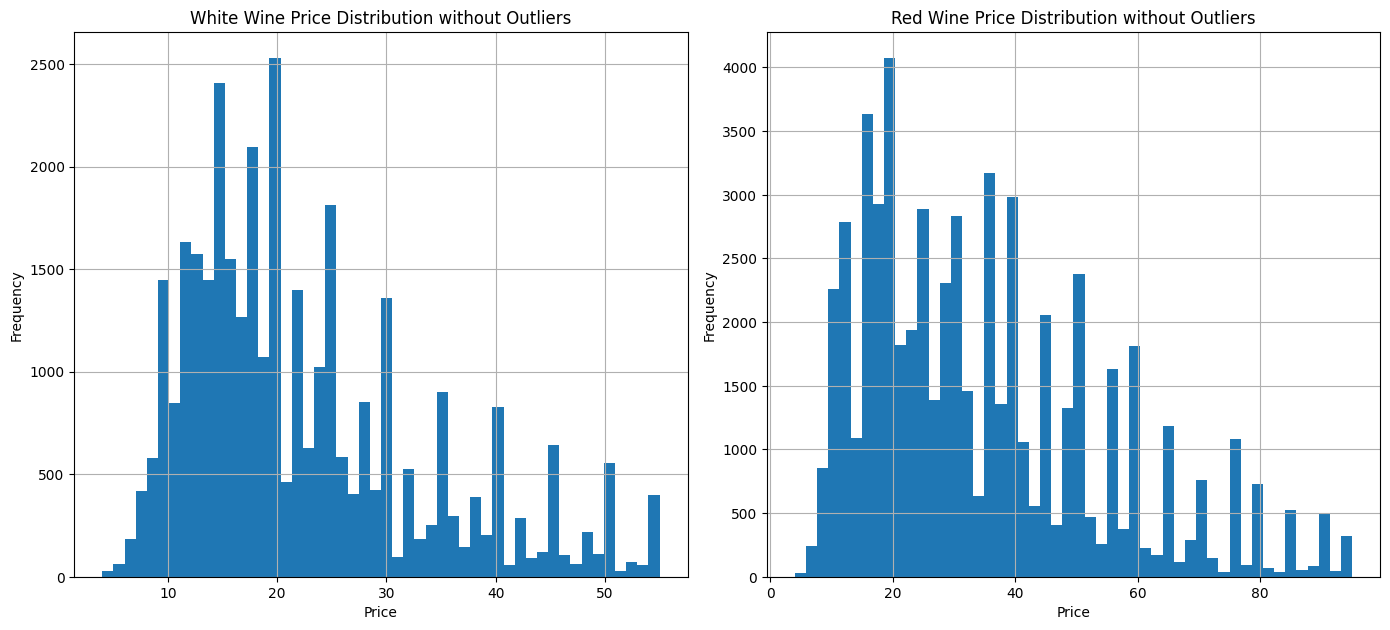

In [277]:
plt.figure(figsize=(14, 12))

# Histogram of prices without outliers for red wines
plt.subplot(2, 2, 2)
df_red_without_outliers['price'].hist(bins=50)
plt.title('Red Wine Price Distribution without Outliers')
plt.xlabel('Price')
plt.ylabel('Frequency')


# Histogram of prices without outliers for white wines
plt.subplot(2, 2, 1)
df_white_without_outliers['price'].hist(bins=50)
plt.title('White Wine Price Distribution without Outliers')
plt.xlabel('Price')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [279]:
red_wine_ratings = df_red_without_outliers[df_red_without_outliers['wine_type'] == 'Red']['points']
white_wine_ratings = df_white_without_outliers[df_white_without_outliers['wine_type'] == 'White']['points']

# Perform independent t-test
t_stat, p_value = stats.ttest_ind(red_wine_ratings, white_wine_ratings, equal_var=False)

print(f"t-statistic: {t_stat}, p-value: {p_value}")

# Interpretation
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference in the average ratings between red and white wines.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference in the average ratings between red and white wines.")

t-statistic: 38.33327464974308, p-value: 0.0
Reject the null hypothesis: There is a significant difference in the average ratings between red and white wines.


In [280]:
mean_red_rating = red_wine_ratings.mean()
mean_white_rating = white_wine_ratings.mean()

print(f"Mean rating for red wines: {mean_red_rating}")
print(f"Mean rating for white wines: {mean_white_rating}")

if p_value < alpha:
    conclusion = "There is a significant difference in the average ratings between red and white wines."
else:
    conclusion = "There is no significant difference in the average ratings between red and white wines."

print(conclusion)

Mean rating for red wines: 88.4950613336923
Mean rating for white wines: 87.7409402546523
There is a significant difference in the average ratings between red and white wines.


Even if the mean ratings are close, the large sample size and possibly low variance can lead to a statistically significant difference. The t-test assesses whether the means are different given the sample size and variance, and in this case, it indicates a significant difference despite the means being close. This is a good example of how statistical significance does not always imply practical significance.

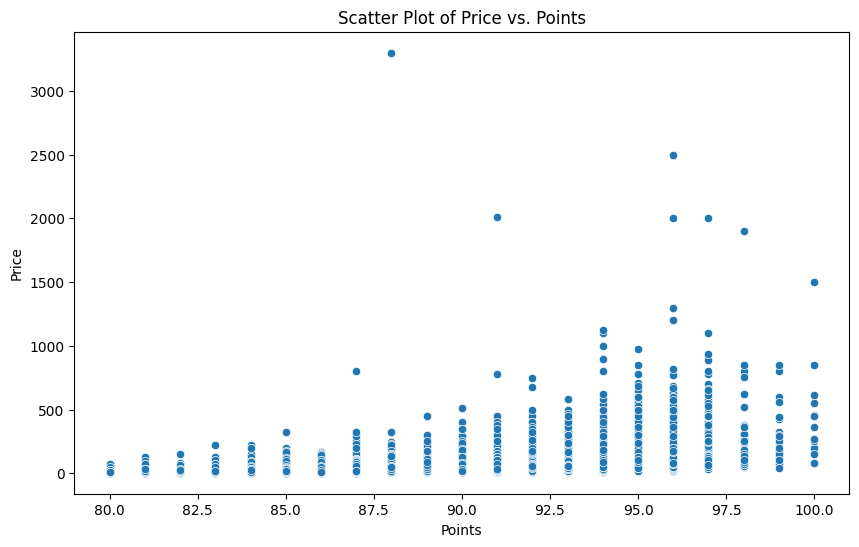

In [266]:
# 3
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='points', y='price')
plt.title('Scatter Plot of Price vs. Points')
plt.xlabel('Points')
plt.ylabel('Price')
plt.show()

In [267]:
correlation, p_value = stats.pearsonr(df['price'], df['points'])

print(f"Pearson correlation coefficient: {correlation}, p-value: {p_value}")

# Interpretation
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant correlation between the price and rating of wine.")
else:
    print("Fail to reject the null hypothesis: There is no significant correlation between the price and rating of wine.")

Pearson correlation coefficient: 0.41687191386891065, p-value: 0.0
Reject the null hypothesis: There is a significant correlation between the price and rating of wine.


In [268]:
def pearson_confidence_interval(r, n, alpha=0.05):
    r_z = np.arctanh(r)  # Fisher transformation
    se = 1 / np.sqrt(n - 3)
    z = stats.norm.ppf(1 - alpha / 2)
    ci_low = r_z - z * se
    ci_high = r_z + z * se
    return np.tanh(ci_low), np.tanh(ci_high)

n = len(df['price'])
ci_low, ci_high = pearson_confidence_interval(correlation, n)

print(f"95% confidence interval for the Pearson correlation coefficient: ({ci_low}, {ci_high})")

95% confidence interval for the Pearson correlation coefficient: (0.41173654451274294, 0.42198080818144457)


# Confidence Intervals

 Wine Ratings Confidence Intervals By Country

95% Confidence Interval for the Mean Points of Wines: (88.43635001411423, 88.47506746627636)


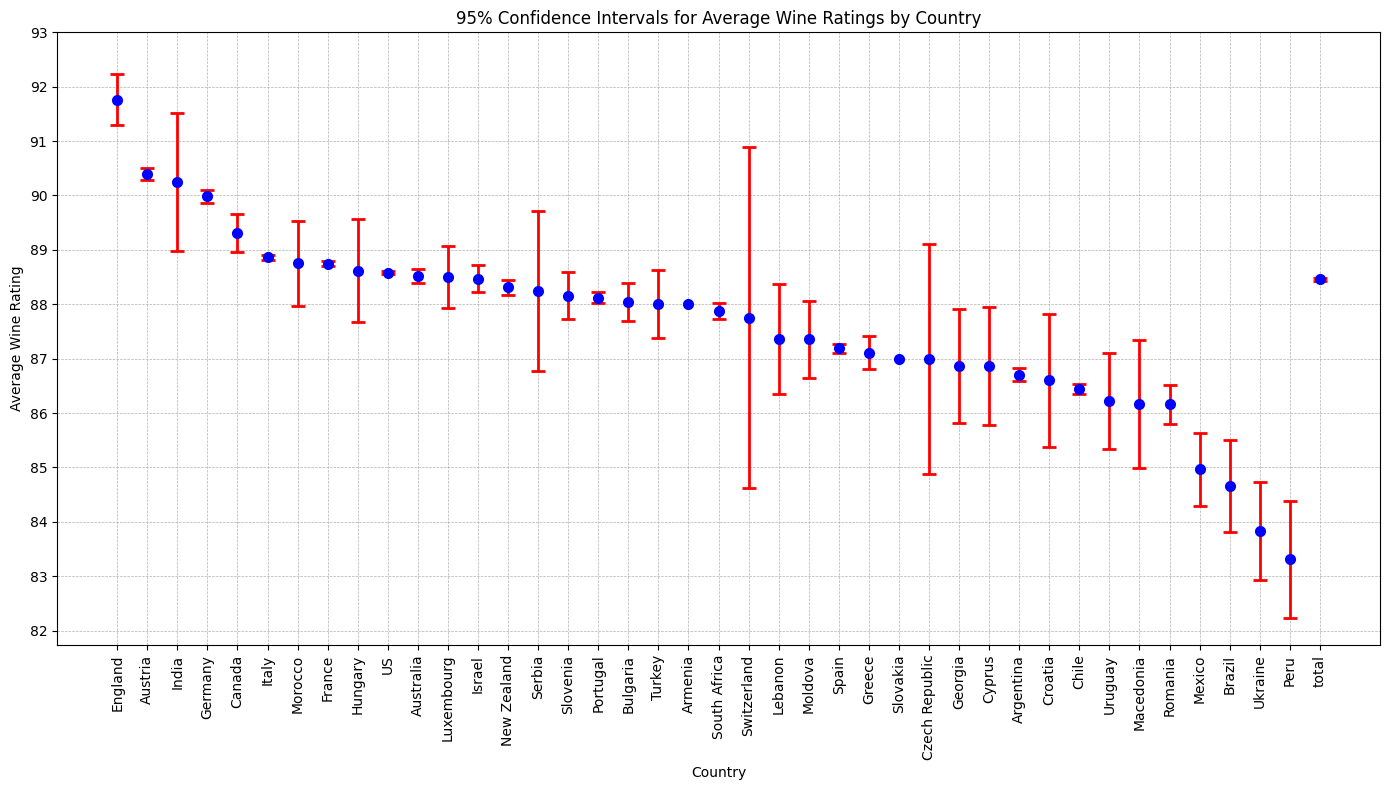

,Country,Mean,Lower CI,Upper CI
19,England,91.762712,91.292833,92.232591
9,Austria,90.400961,90.289537,90.512385
26,India,90.250000,88.980338,91.519662
3,Germany,89.984243,89.869420,90.099066
22,Canada,89.305263,88.954780,89.655746
6,Italy,88.860273,88.811587,88.908958
24,Morocco,88.750000,87.972814,89.527186
2,France,88.744547,88.695426,88.793667
16,Hungary,88.619048,87.667471,89.570624
1,US,88.583747,88.555317,88.612176


In [281]:
# Calculate mean and standard error
mean_points = df['points'].mean()
sem_points = stats.sem(df['points'].dropna())

# Calculate the confidence interval
confidence_interval = stats.t.interval(0.95, len(df['points'])-1, loc=mean_points, scale=sem_points)
print(f'95% Confidence Interval for the Mean Points of Wines: {confidence_interval}')


# Calculate mean and confidence interval for each country
countries = df['country'].unique()
confidence_intervals = []

for country in countries:
    country_data = df[df['country'] == country]['points']
    mean = np.mean(country_data)
    confidence = stats.norm.interval(0.95, loc=mean, scale=stats.sem(country_data))
    confidence_intervals.append((country, mean, confidence[0], confidence[1]))

# Create a DataFrame for better visualization
confidence_df = pd.DataFrame(confidence_intervals, columns=['Country', 'Mean', 'Lower CI', 'Upper CI'])
confidence_df = confidence_df.sort_values(by='Mean', ascending=False)
#confidence_df = confidence_df.append('total', mean_points, confidence_interval[0], confidence_interval[1])

general_row = {'Country': 'total', 'Mean': mean_points, 'Lower CI': confidence_interval[0], 'Upper CI': confidence_interval[1]}
confidence_df.loc[len(confidence_df)] = general_row


# Plotting the confidence intervals
plt.figure(figsize=(14, 8))
plt.errorbar(confidence_df['Country'], confidence_df['Mean'], 
             yerr=[confidence_df['Mean'] - confidence_df['Lower CI'], confidence_df['Upper CI'] - confidence_df['Mean']], 
             fmt='o', ecolor='r', capsize=5, elinewidth=2, markeredgewidth=2, color='blue')
plt.xticks(rotation=90)
plt.xlabel('Country')
plt.ylabel('Average Wine Rating')
plt.title('95% Confidence Intervals for Average Wine Ratings by Country')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.yticks(np.arange(82, 94, 1))

plt.show()

confidence_df

95% Confidence Interval for the Mean Price of Wines: (36.09841007498239, 36.63041976334001)


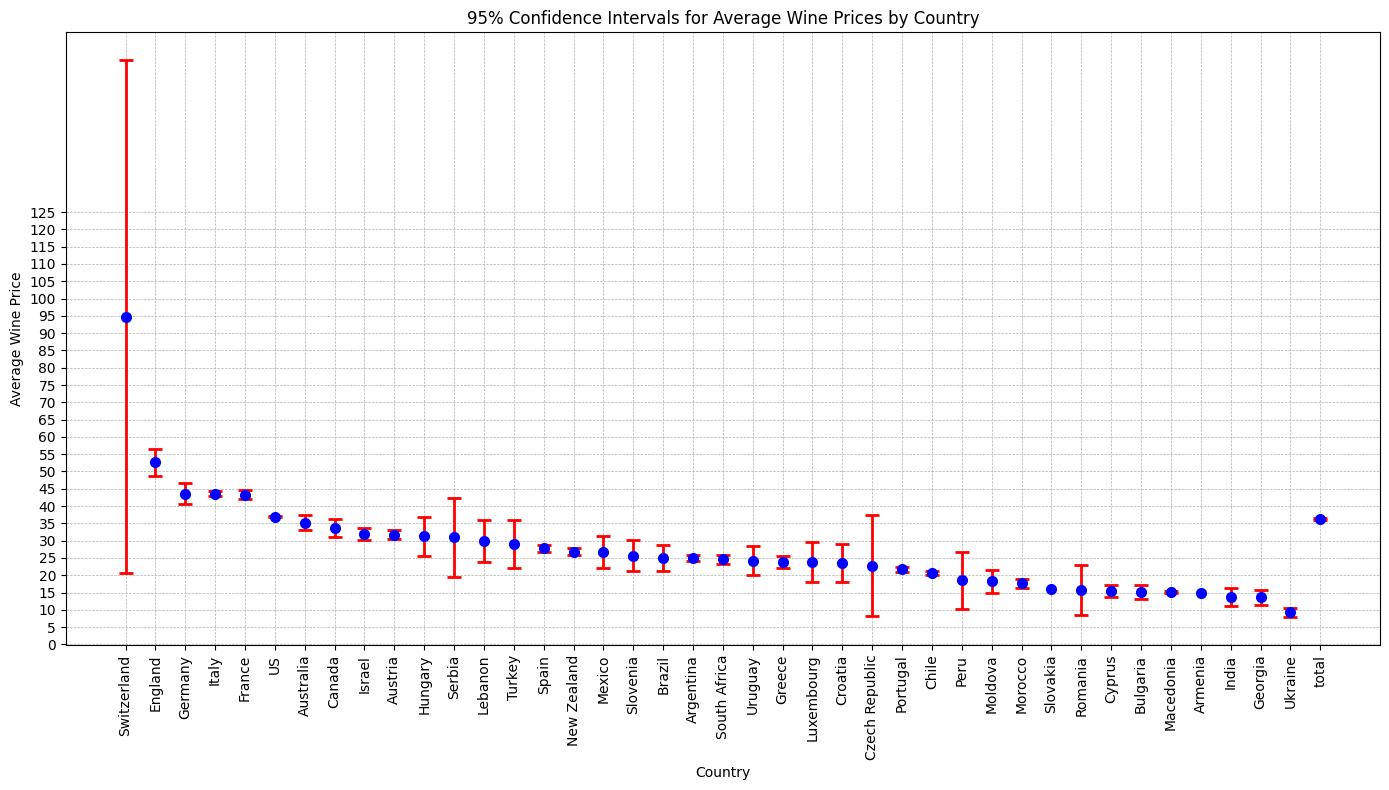

,Country,Mean,Lower CI,Upper CI
35,Switzerland,94.750000,20.601447,168.898553
19,England,52.677966,48.745903,56.610029
3,Germany,43.631401,40.511071,46.751731
6,Italy,43.517851,42.781971,44.253732
2,France,43.289685,42.036194,44.543175
1,US,36.957564,36.708210,37.206919
8,Australia,35.253927,33.003146,37.504708
22,Canada,33.657895,30.974193,36.341597
12,Israel,31.922141,30.063918,33.780364
9,Austria,31.779498,30.391784,33.167212


In [282]:
# Calculate mean and standard error for the entire dataset for 'price'
mean_price = df['price'].mean()
sem_price = stats.sem(df['price'].dropna())

# Calculate the confidence interval for the entire dataset for 'price'
confidence_interval_price = stats.t.interval(0.95, len(df['price'].dropna())-1, loc=mean_price, scale=sem_price)
print(f'95% Confidence Interval for the Mean Price of Wines: {confidence_interval_price}')

# Calculate mean and confidence interval for each country for 'price'
countries = df['country'].unique()
confidence_intervals_price = []

for country in countries:
    country_data = df[df['country'] == country]['price']
    mean = np.mean(country_data)
    confidence = stats.norm.interval(0.95, loc=mean, scale=stats.sem(country_data))
    confidence_intervals_price.append((country, mean, confidence[0], confidence[1]))

# Create a DataFrame for better visualization
confidence_df_price = pd.DataFrame(confidence_intervals_price, columns=['Country', 'Mean', 'Lower CI', 'Upper CI'])
confidence_df_price = confidence_df_price.sort_values(by='Mean', ascending=False)

# Append the total statistics to the country data for 'price'
general_row_price = {'Country': 'total', 'Mean': mean_price, 'Lower CI': confidence_interval_price[0], 'Upper CI': confidence_interval_price[1]}
confidence_df_price.loc[len(confidence_df_price)] = general_row_price

# Plotting the confidence intervals for 'price'
plt.figure(figsize=(14, 8))
plt.errorbar(confidence_df_price['Country'], confidence_df_price['Mean'], 
             yerr=[confidence_df_price['Mean'] - confidence_df_price['Lower CI'], confidence_df_price['Upper CI'] - confidence_df_price['Mean']], 
             fmt='o', ecolor='r', capsize=5, elinewidth=2, markeredgewidth=2, color='blue')
plt.xticks(rotation=90)
plt.xlabel('Country')
plt.ylabel('Average Wine Price')
plt.title('95% Confidence Intervals for Average Wine Prices by Country')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.yticks(np.arange(0, 130, 5))  # Adjust this range based on your 'price' data

plt.show()

confidence_df_price

Comparison

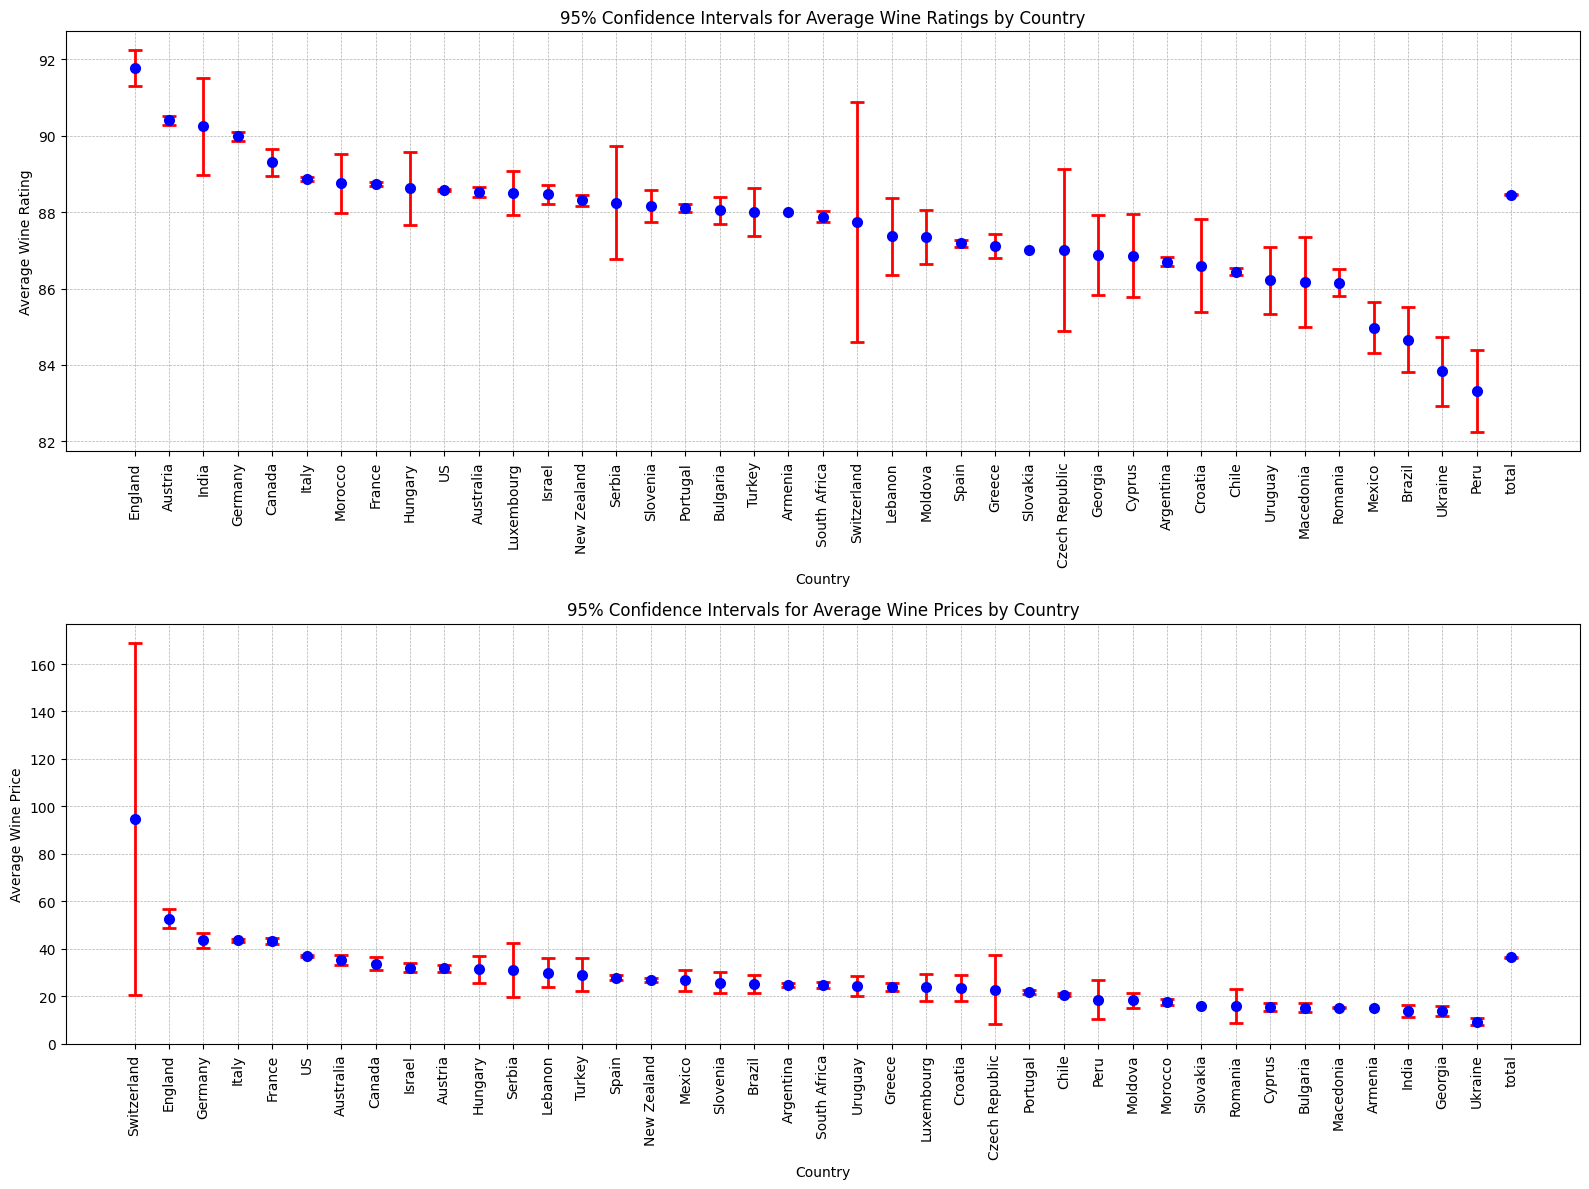

In [283]:
# Plotting the confidence intervals for both wine ratings and prices side by side

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12))

# Plot for wine ratings
ax1.errorbar(confidence_df['Country'], confidence_df['Mean'], 
             yerr=[confidence_df['Mean'] - confidence_df['Lower CI'], confidence_df['Upper CI'] - confidence_df['Mean']], 
             fmt='o', ecolor='r', capsize=5, elinewidth=2, markeredgewidth=2, color='blue')
ax1.set_xticklabels(confidence_df['Country'], rotation=90)
ax1.set_xlabel('Country')
ax1.set_ylabel('Average Wine Rating')
ax1.set_title('95% Confidence Intervals for Average Wine Ratings by Country')
ax1.grid(True, linestyle='--', linewidth=0.5)

# Plot for wine prices
ax2.errorbar(confidence_df_price['Country'], confidence_df_price['Mean'], 
             yerr=[confidence_df_price['Mean'] - confidence_df_price['Lower CI'], confidence_df_price['Upper CI'] - confidence_df_price['Mean']], 
             fmt='o', ecolor='r', capsize=5, elinewidth=2, markeredgewidth=2, color='blue')
ax2.set_xticklabels(confidence_df_price['Country'], rotation=90)
ax2.set_xlabel('Country')
ax2.set_ylabel('Average Wine Price')
ax2.set_title('95% Confidence Intervals for Average Wine Prices by Country')
ax2.grid(True, linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

Comparison

95% Confidence Interval for the Mean Points of Wines: (88.43635001411423, 88.47506746627636)
95% Confidence Interval for the Mean Price of Wines: (36.09841007498239, 36.63041976334001)


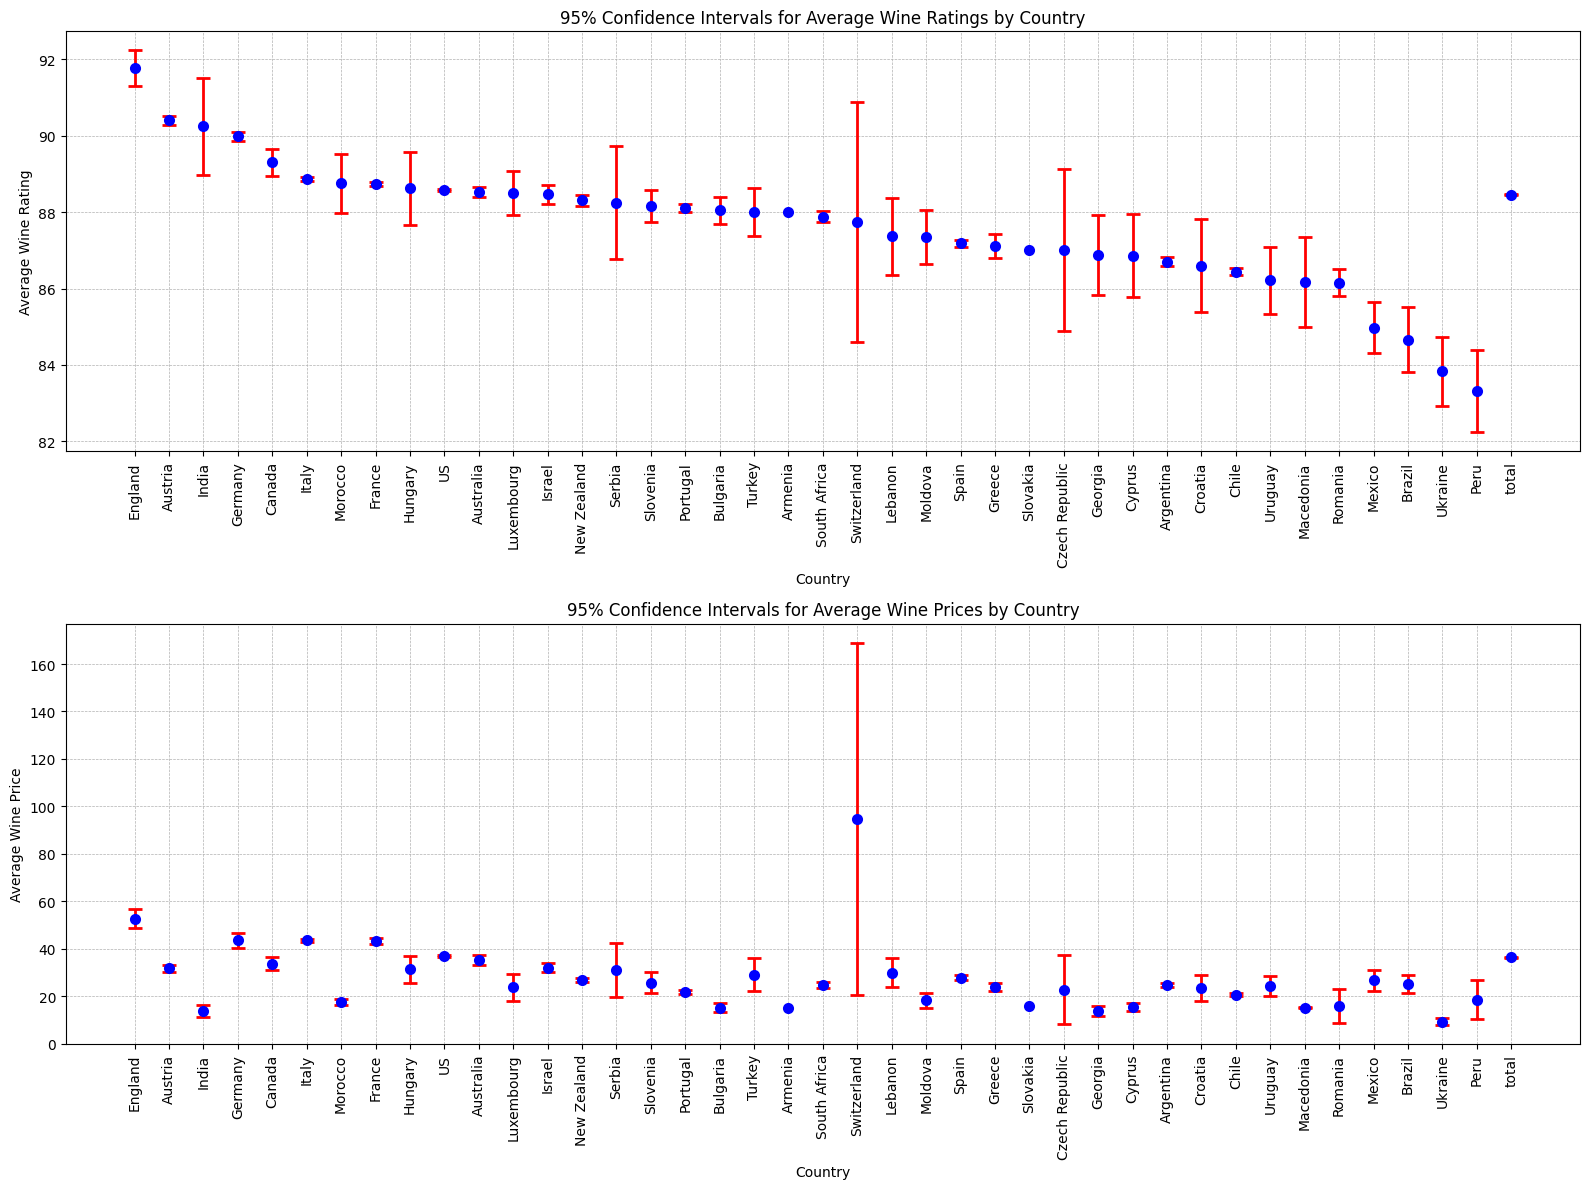

In [284]:
# Calculate mean and standard error for the entire dataset for 'points'
mean_points = df['points'].mean()
sem_points = stats.sem(df['points'].dropna())

# Calculate the confidence interval for the entire dataset for 'points'
confidence_interval_points = stats.t.interval(0.95, len(df['points'].dropna())-1, loc=mean_points, scale=sem_points)
print(f'95% Confidence Interval for the Mean Points of Wines: {confidence_interval_points}')

# Calculate mean and confidence interval for each country for 'points'
countries = df['country'].unique()
confidence_intervals_points = []

for country in countries:
    country_data = df[df['country'] == country]['points']
    mean = np.mean(country_data)
    confidence = stats.norm.interval(0.95, loc=mean, scale=stats.sem(country_data))
    confidence_intervals_points.append((country, mean, confidence[0], confidence[1]))

# Create a DataFrame for better visualization
confidence_df_points = pd.DataFrame(confidence_intervals_points, columns=['Country', 'Mean', 'Lower CI', 'Upper CI'])
confidence_df_points = confidence_df_points.sort_values(by='Mean', ascending=False)

# Append the total statistics to the country data for 'points'
general_row_points = {'Country': 'total', 'Mean': mean_points, 'Lower CI': confidence_interval_points[0], 'Upper CI': confidence_interval_points[1]}
confidence_df_points.loc[len(confidence_df_points)] = general_row_points

# Calculate mean and standard error for the entire dataset for 'price'
mean_price = df['price'].mean()
sem_price = stats.sem(df['price'].dropna())

# Calculate the confidence interval for the entire dataset for 'price'
confidence_interval_price = stats.t.interval(0.95, len(df['price'].dropna())-1, loc=mean_price, scale=sem_price)
print(f'95% Confidence Interval for the Mean Price of Wines: {confidence_interval_price}')

# Calculate mean and confidence interval for each country for 'price'
confidence_intervals_price = []

for country in countries:
    country_data = df[df['country'] == country]['price']
    mean = np.mean(country_data)
    confidence = stats.norm.interval(0.95, loc=mean, scale=stats.sem(country_data))
    confidence_intervals_price.append((country, mean, confidence[0], confidence[1]))

# Create a DataFrame for better visualization
confidence_df_price = pd.DataFrame(confidence_intervals_price, columns=['Country', 'Mean', 'Lower CI', 'Upper CI'])

# Align the order of countries in 'confidence_df_price' to match 'confidence_df_points'
confidence_df_price = confidence_df_price.set_index('Country').reindex(confidence_df_points['Country']).reset_index()

# Append the total statistics to the country data for 'price'
general_row_price = {'Country': 'total', 'Mean': mean_price, 'Lower CI': confidence_interval_price[0], 'Upper CI': confidence_interval_price[1]}
confidence_df_price.loc[len(confidence_df_price)] = general_row_price

# Plotting the confidence intervals for both wine ratings and prices side by side
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12))

# Plot for wine ratings
ax1.errorbar(confidence_df_points['Country'], confidence_df_points['Mean'], 
             yerr=[confidence_df_points['Mean'] - confidence_df_points['Lower CI'], confidence_df_points['Upper CI'] - confidence_df_points['Mean']], 
             fmt='o', ecolor='r', capsize=5, elinewidth=2, markeredgewidth=2, color='blue')
ax1.set_xticklabels(confidence_df_points['Country'], rotation=90)
ax1.set_xlabel('Country')
ax1.set_ylabel('Average Wine Rating')
ax1.set_title('95% Confidence Intervals for Average Wine Ratings by Country')
ax1.grid(True, linestyle='--', linewidth=0.5)

# Plot for wine prices
ax2.errorbar(confidence_df_price['Country'], confidence_df_price['Mean'], 
             yerr=[confidence_df_price['Mean'] - confidence_df_price['Lower CI'], confidence_df_price['Upper CI'] - confidence_df_price['Mean']], 
             fmt='o', ecolor='r', capsize=5, elinewidth=2, markeredgewidth=2, color='blue')
ax2.set_xticklabels(confidence_df_price['Country'], rotation=90)
ax2.set_xlabel('Country')
ax2.set_ylabel('Average Wine Price')
ax2.set_title('95% Confidence Intervals for Average Wine Prices by Country')
ax2.grid(True, linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

95% Confidence Interval for the Mean Points of Wines: (88.43635001411423, 88.47506746627636)
95% Confidence Interval for the Mean Price of Wines: (36.09841007498239, 36.63041976334001)


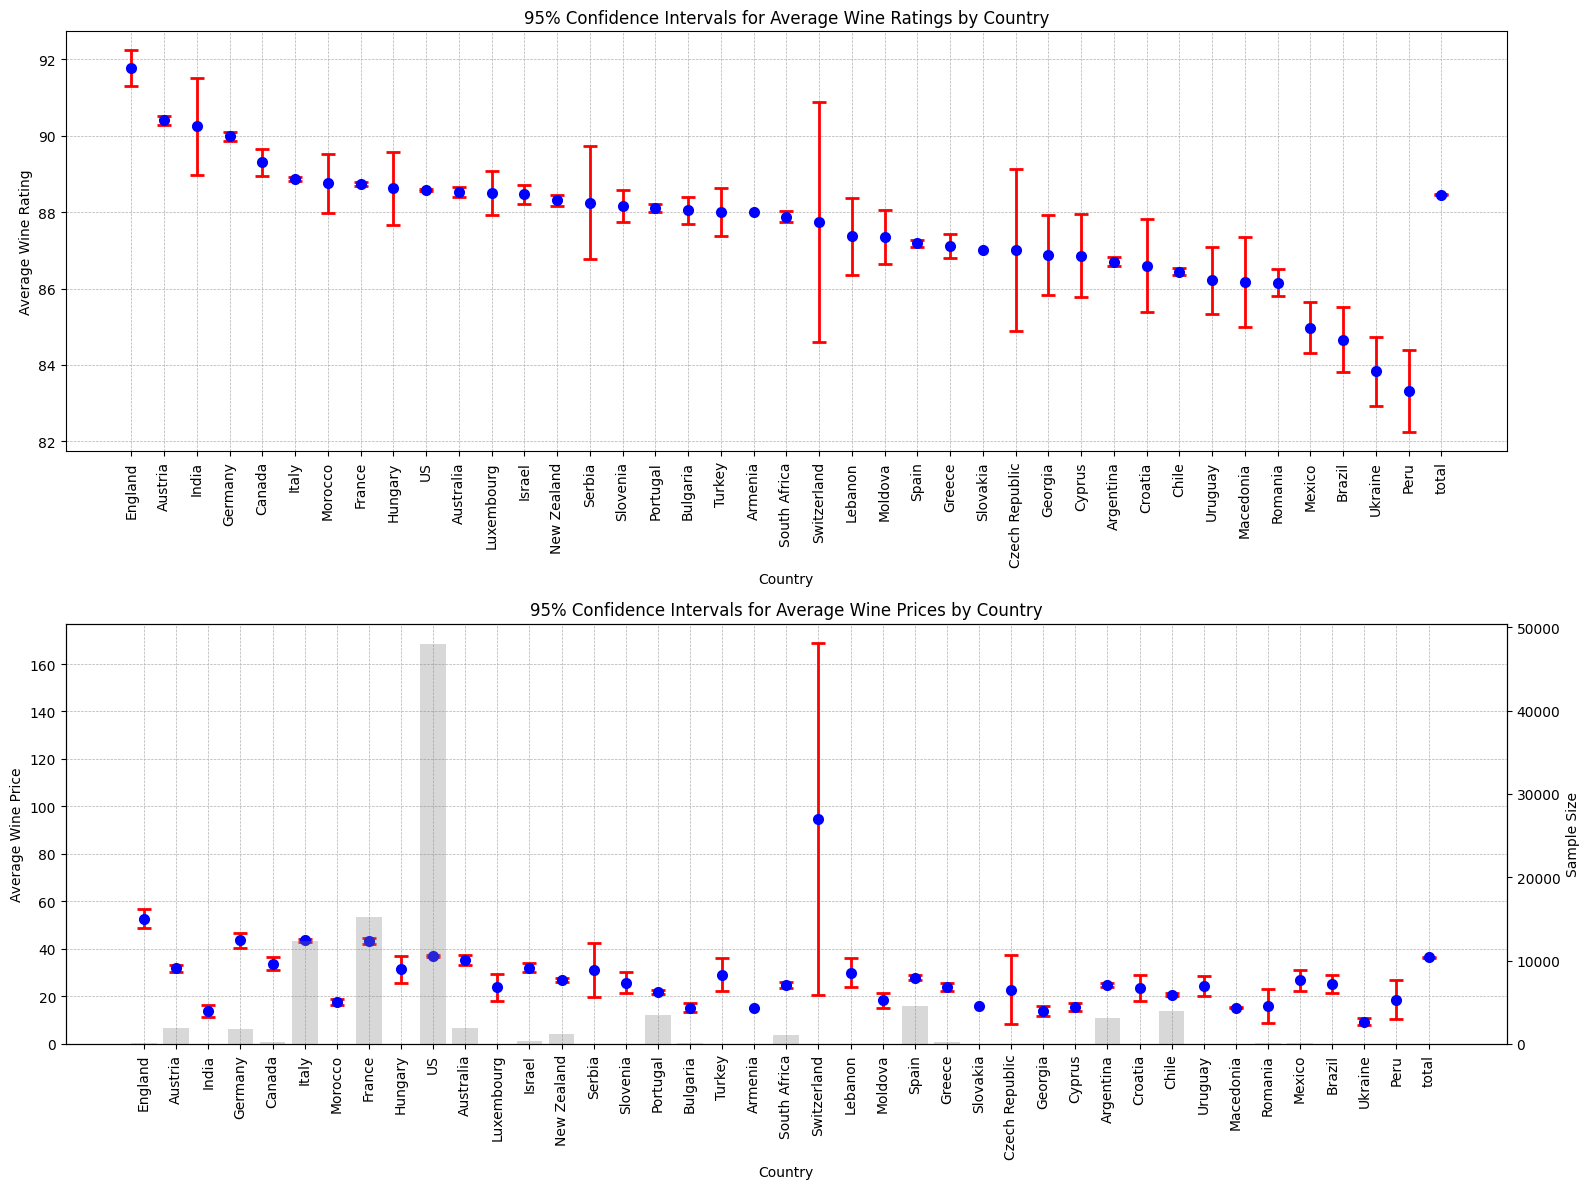

In [285]:
# Calculate mean and standard error for the entire dataset for 'points'
mean_points = df['points'].mean()
sem_points = stats.sem(df['points'].dropna())

# Calculate the confidence interval for the entire dataset for 'points'
confidence_interval_points = stats.t.interval(0.95, len(df['points'].dropna())-1, loc=mean_points, scale=sem_points)
print(f'95% Confidence Interval for the Mean Points of Wines: {confidence_interval_points}')

# Calculate mean and confidence interval for each country for 'points'
countries = df['country'].unique()
confidence_intervals_points = []

for country in countries:
    country_data = df[df['country'] == country]['points']
    mean = np.mean(country_data)
    confidence = stats.norm.interval(0.95, loc=mean, scale=stats.sem(country_data))
    confidence_intervals_points.append((country, mean, confidence[0], confidence[1]))

# Create a DataFrame for better visualization
confidence_df_points = pd.DataFrame(confidence_intervals_points, columns=['Country', 'Mean', 'Lower CI', 'Upper CI'])
confidence_df_points = confidence_df_points.sort_values(by='Mean', ascending=False)

# Append the total statistics to the country data for 'points'
general_row_points = {'Country': 'total', 'Mean': mean_points, 'Lower CI': confidence_interval_points[0], 'Upper CI': confidence_interval_points[1]}
confidence_df_points.loc[len(confidence_df_points)] = general_row_points

# Calculate mean and standard error for the entire dataset for 'price'
mean_price = df['price'].mean()
sem_price = stats.sem(df['price'].dropna())

# Calculate the confidence interval for the entire dataset for 'price'
confidence_interval_price = stats.t.interval(0.95, len(df['price'].dropna())-1, loc=mean_price, scale=sem_price)
print(f'95% Confidence Interval for the Mean Price of Wines: {confidence_interval_price}')

# Calculate mean and confidence interval for each country for 'price'
confidence_intervals_price = []

for country in countries:
    country_data = df[df['country'] == country]['price']
    mean = np.mean(country_data)
    confidence = stats.norm.interval(0.95, loc=mean, scale=stats.sem(country_data))
    confidence_intervals_price.append((country, mean, confidence[0], confidence[1]))

# Create a DataFrame for better visualization
confidence_df_price = pd.DataFrame(confidence_intervals_price, columns=['Country', 'Mean', 'Lower CI', 'Upper CI'])

# Align the order of countries in 'confidence_df_price' to match 'confidence_df_points'
confidence_df_price = confidence_df_price.set_index('Country').reindex(confidence_df_points['Country']).reset_index()

# Append the total statistics to the country data for 'price'
general_row_price = {'Country': 'total', 'Mean': mean_price, 'Lower CI': confidence_interval_price[0], 'Upper CI': confidence_interval_price[1]}
confidence_df_price.loc[len(confidence_df_price)] = general_row_price

# Calculate the sample size for each country
sample_sizes = df['country'].value_counts().reindex(confidence_df_price['Country']).fillna(0)

# Plotting the confidence intervals for both wine ratings and prices side by side
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12))

# Plot for wine ratings
ax1.errorbar(confidence_df_points['Country'], confidence_df_points['Mean'], 
             yerr=[confidence_df_points['Mean'] - confidence_df_points['Lower CI'], confidence_df_points['Upper CI'] - confidence_df_points['Mean']], 
             fmt='o', ecolor='r', capsize=5, elinewidth=2, markeredgewidth=2, color='blue')
ax1.set_xticklabels(confidence_df_points['Country'], rotation=90)
ax1.set_xlabel('Country')
ax1.set_ylabel('Average Wine Rating')
ax1.set_title('95% Confidence Intervals for Average Wine Ratings by Country')
ax1.grid(True, linestyle='--', linewidth=0.5)

# Plot for wine prices with histogram for sample sizes
ax2.errorbar(confidence_df_price['Country'], confidence_df_price['Mean'], 
             yerr=[confidence_df_price['Mean'] - confidence_df_price['Lower CI'], confidence_df_price['Upper CI'] - confidence_df_price['Mean']], 
             fmt='o', ecolor='r', capsize=5, elinewidth=2, markeredgewidth=2, color='blue')
ax2.set_xticklabels(confidence_df_price['Country'], rotation=90)
ax2.set_xlabel('Country')
ax2.set_ylabel('Average Wine Price')
ax2.set_title('95% Confidence Intervals for Average Wine Prices by Country')
ax2.grid(True, linestyle='--', linewidth=0.5)

# Secondary y-axis for sample sizes histogram
ax3 = ax2.twinx()
ax3.bar(confidence_df_price['Country'], sample_sizes, alpha=0.3, color='grey')
ax3.set_ylabel('Sample Size')

plt.tight_layout()
plt.show()

Dataset size: 99952
95% Confidence Interval for the Mean Points of Wines: (88.43635001411423, 88.47506746627636)
95% Confidence Interval for the Mean Price of Wines: (36.09841007498239, 36.63041976334001)


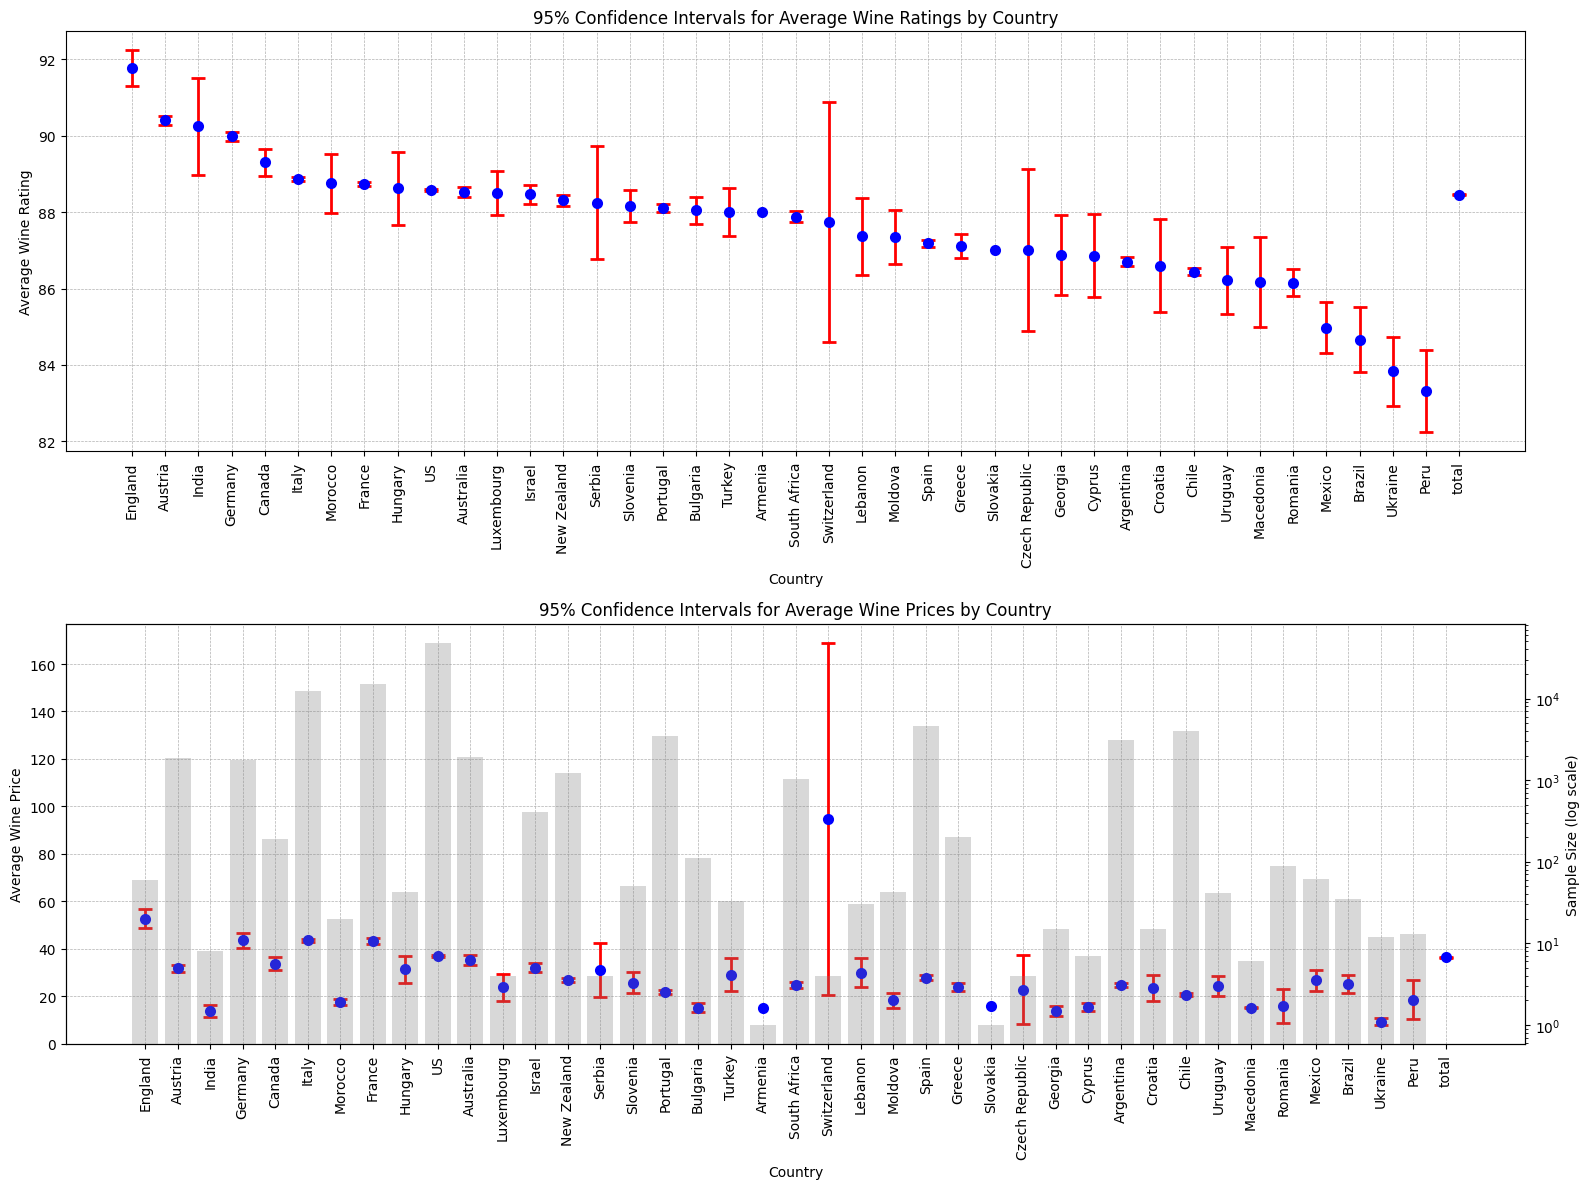

In [286]:
print(f"Dataset size: {len(df)}")

# Calculate mean and standard error for the entire dataset for 'points'
mean_points = df['points'].mean()
sem_points = stats.sem(df['points'].dropna())

# Calculate the confidence interval for the entire dataset for 'points'
confidence_interval_points = stats.t.interval(0.95, len(df['points'].dropna())-1, loc=mean_points, scale=sem_points)
print(f'95% Confidence Interval for the Mean Points of Wines: {confidence_interval_points}')

# Calculate mean and confidence interval for each country for 'points'
countries = df['country'].unique()
confidence_intervals_points = []

for country in countries:
    country_data = df[df['country'] == country]['points']
    mean = np.mean(country_data)
    confidence = stats.norm.interval(0.95, loc=mean, scale=stats.sem(country_data))
    confidence_intervals_points.append((country, mean, confidence[0], confidence[1]))

# Create a DataFrame for better visualization
confidence_df_points = pd.DataFrame(confidence_intervals_points, columns=['Country', 'Mean', 'Lower CI', 'Upper CI'])
confidence_df_points = confidence_df_points.sort_values(by='Mean', ascending=False)

# Append the total statistics to the country data for 'points'
general_row_points = {'Country': 'total', 'Mean': mean_points, 'Lower CI': confidence_interval_points[0], 'Upper CI': confidence_interval_points[1]}
confidence_df_points.loc[len(confidence_df_points)] = general_row_points

# Calculate mean and standard error for the entire dataset for 'price'
mean_price = df['price'].mean()
sem_price = stats.sem(df['price'].dropna())

# Calculate the confidence interval for the entire dataset for 'price'
confidence_interval_price = stats.t.interval(0.95, len(df['price'].dropna())-1, loc=mean_price, scale=sem_price)
print(f'95% Confidence Interval for the Mean Price of Wines: {confidence_interval_price}')

# Calculate mean and confidence interval for each country for 'price'
confidence_intervals_price = []

for country in countries:
    country_data = df[df['country'] == country]['price']
    mean = np.mean(country_data)
    confidence = stats.norm.interval(0.95, loc=mean, scale=stats.sem(country_data))
    confidence_intervals_price.append((country, mean, confidence[0], confidence[1]))

# Create a DataFrame for better visualization
confidence_df_price = pd.DataFrame(confidence_intervals_price, columns=['Country', 'Mean', 'Lower CI', 'Upper CI'])

# Align the order of countries in 'confidence_df_price' to match 'confidence_df_points'
confidence_df_price = confidence_df_price.set_index('Country').reindex(confidence_df_points['Country']).reset_index()

# Append the total statistics to the country data for 'price'
general_row_price = {'Country': 'total', 'Mean': mean_price, 'Lower CI': confidence_interval_price[0], 'Upper CI': confidence_interval_price[1]}
confidence_df_price.loc[len(confidence_df_price)] = general_row_price

# Calculate the sample size for each country
sample_sizes = df['country'].value_counts().reindex(confidence_df_price['Country']).fillna(0)

# Plotting the confidence intervals for both wine ratings and prices side by side
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12))

# Plot for wine ratings
ax1.errorbar(confidence_df_points['Country'], confidence_df_points['Mean'], 
             yerr=[confidence_df_points['Mean'] - confidence_df_points['Lower CI'], confidence_df_points['Upper CI'] - confidence_df_points['Mean']], 
             fmt='o', ecolor='r', capsize=5, elinewidth=2, markeredgewidth=2, color='blue')
ax1.set_xticklabels(confidence_df_points['Country'], rotation=90)
ax1.set_xlabel('Country')
ax1.set_ylabel('Average Wine Rating')
ax1.set_title('95% Confidence Intervals for Average Wine Ratings by Country')
ax1.grid(True, linestyle='--', linewidth=0.5)

# Plot for wine prices with histogram for sample sizes
ax2.errorbar(confidence_df_price['Country'], confidence_df_price['Mean'], 
             yerr=[confidence_df_price['Mean'] - confidence_df_price['Lower CI'], confidence_df_price['Upper CI'] - confidence_df_price['Mean']], 
             fmt='o', ecolor='r', capsize=5, elinewidth=2, markeredgewidth=2, color='blue')
ax2.set_xticklabels(confidence_df_price['Country'], rotation=90)
ax2.set_xlabel('Country')
ax2.set_ylabel('Average Wine Price')
ax2.set_title('95% Confidence Intervals for Average Wine Prices by Country')
ax2.grid(True, linestyle='--', linewidth=0.5)

# Secondary y-axis for sample sizes histogram with log scale
ax3 = ax2.twinx()
ax3.bar(confidence_df_price['Country'], sample_sizes, alpha=0.3, color='grey')
ax3.set_ylabel('Sample Size (log scale)')
ax3.set_yscale('log')

plt.tight_layout()
plt.show()

95% Confidence Interval for the Mean Points of Wines: (88.43635001411423, 88.47506746627636)


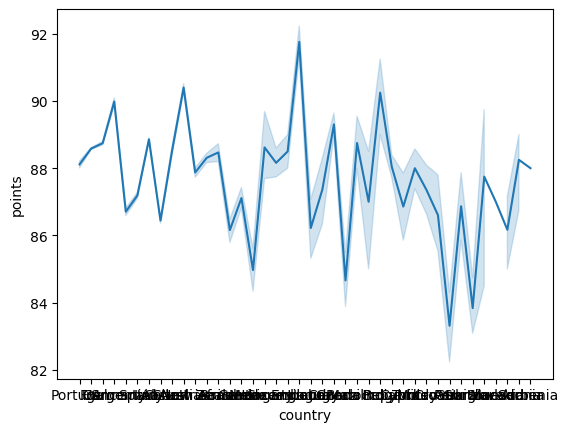

In [287]:
# Calculate mean and standard error
mean_points = df['points'].mean()
sem_points = stats.sem(df['points'].dropna())

# Calculate the confidence interval
confidence_interval = stats.t.interval(0.95, len(df['points'])-1, loc=mean_points, scale=sem_points)
print(f'95% Confidence Interval for the Mean Points of Wines: {confidence_interval}')

mean = mean_points
lower_ci, upper_ci = confidence_interval
yerr = [[mean - lower_ci], [upper_ci - mean]]


# line plot with 95% confidence interval
sns.lineplot(data=df, x="country", y="points", errorbar="ci")
plt.show()

In [251]:
# Calculate mean and standard error
mean_points = df['points'].mean()
sem_points = stats.sem(df['points'].dropna())

# Calculate the confidence interval
confidence_interval = stats.t.interval(0.95, len(df['points'].dropna())-1, loc=mean_points, scale=sem_points)
print(f'95% Confidence Interval for the Mean Points of Wines: {confidence_interval}')

95% Confidence Interval for the Mean Points of Wines: (88.43635001411423, 88.47506746627636)


In [252]:
# Calculate mean and standard error
mean_price = df['price'].mean()
sem_price = stats.sem(df['price'].dropna())

# Calculate the confidence interval
confidence_interval = stats.t.interval(0.95, len(df['price'].dropna())-1, loc=mean_price, scale=sem_price)
print(f'95% Confidence Interval for the Mean Price of Wines: {confidence_interval}')

95% Confidence Interval for the Mean Price of Wines: (36.09841007498239, 36.63041976334001)


# Linear Regression and correlation analysis

## Scatterplots and Correlation

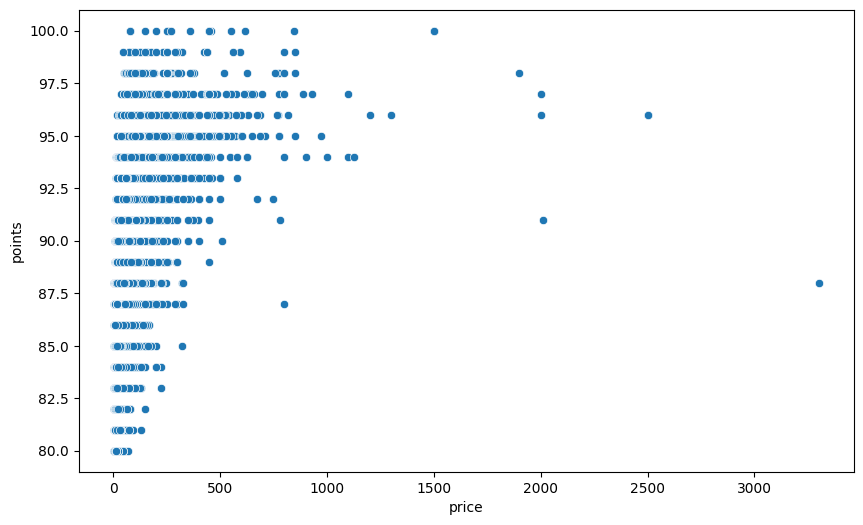

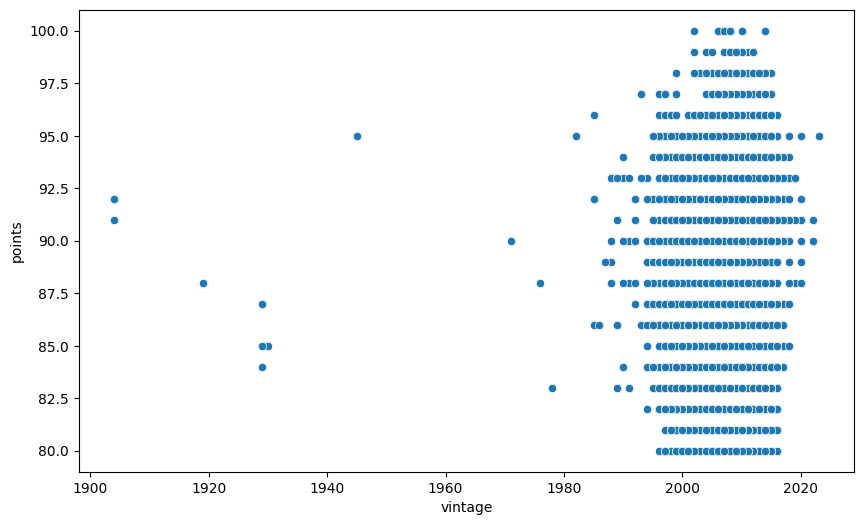

In [253]:
for i in ['price', 'vintage']:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x=i, y="points")
    plt.show()


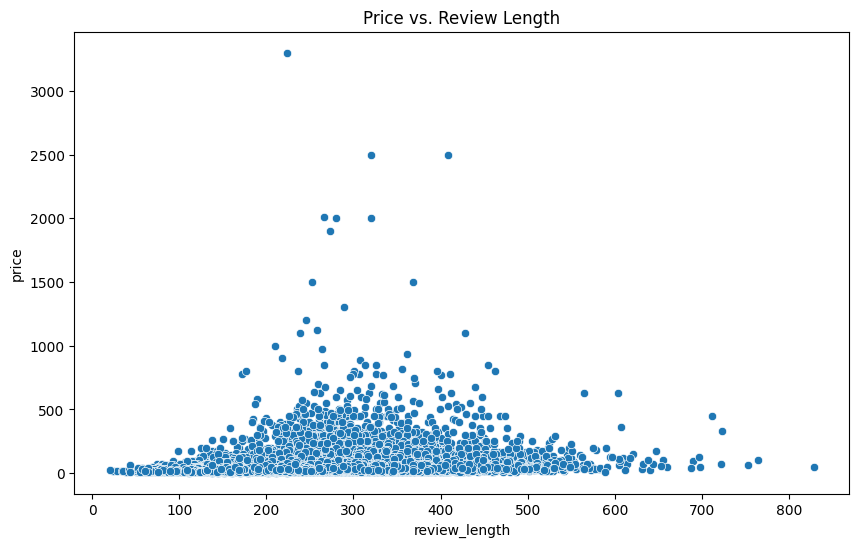

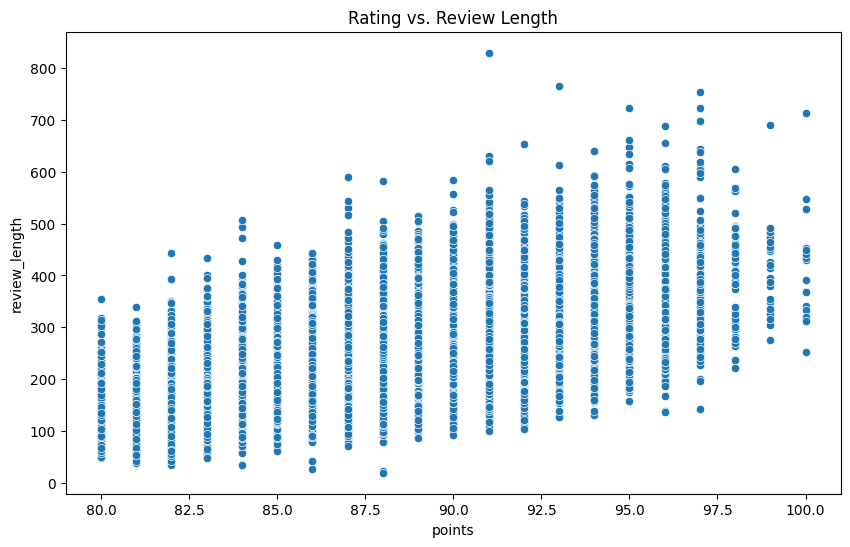

In [254]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='review_length', y='price', data=df)
plt.title('Price vs. Review Length')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='points', y='review_length', data=df)
plt.title('Rating vs. Review Length')
plt.show()

<Figure size 1000x600 with 0 Axes>

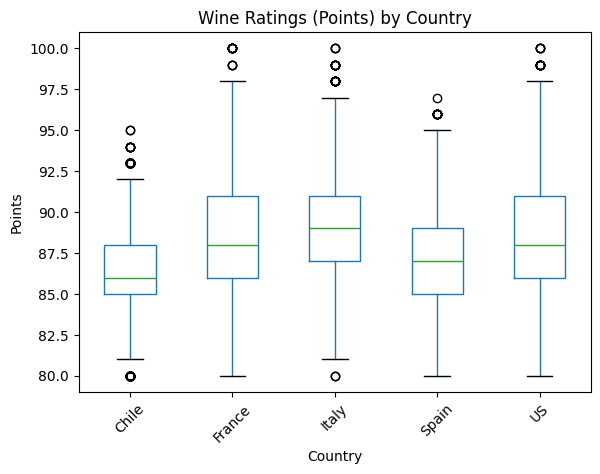

In [255]:
# Select top 10 countries by the number of wine reviews
top_countries = df['country'].value_counts().head(5).index
top_countries_data = df[df['country'].isin(top_countries)]

# Box plot for points by country
plt.figure(figsize=(10, 6))
top_countries_data.boxplot(column='points', by='country', grid=False)
plt.title('Wine Ratings (Points) by Country')
plt.suptitle('')
plt.xlabel('Country')
plt.ylabel('Points')
plt.xticks(rotation=45)
plt.show()

<Figure size 1200x800 with 0 Axes>

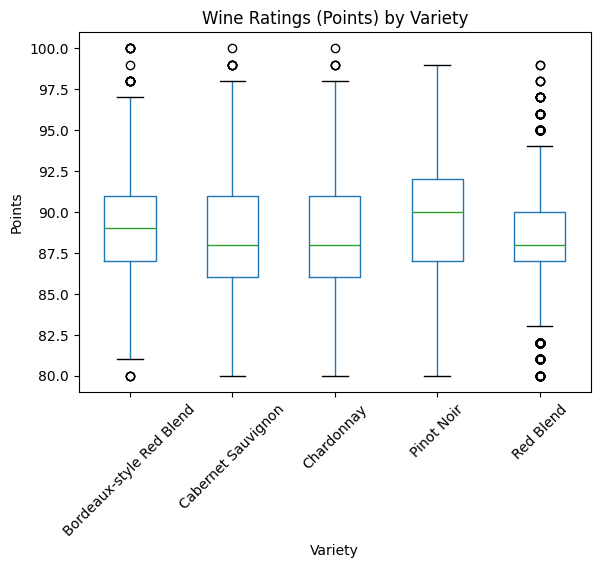

In [256]:
# Select top 10 varieties by the number of wine reviews
top_varieties = df['variety'].value_counts().head(5).index
top_varieties_data = df[df['variety'].isin(top_varieties)]

# Box plot for points by variety
plt.figure(figsize=(12, 8))
top_varieties_data.boxplot(column='points', by='variety', grid=False)
plt.title('Wine Ratings (Points) by Variety')
plt.suptitle('')
plt.xlabel('Variety')
plt.ylabel('Points')
plt.xticks(rotation=45)
plt.show()

Index(['points', 'price', 'is_outlier', 'vintage', 'review_length',
       'wine_type', 'country_Chile', 'country_France', 'country_Italy',
       'country_Spain', 'country_US', 'variety_Bordeaux-style Red Blend',
       'variety_Cabernet Sauvignon', 'variety_Chardonnay',
       'variety_Pinot Noir', 'variety_Red Blend'],
      dtype='object')
points                                int64
price                               float64
is_outlier                             bool
vintage                               Int64
review_length                         int64
wine_type                            object
country_Chile                          bool
country_France                         bool
country_Italy                          bool
country_Spain                          bool
country_US                             bool
variety_Bordeaux-style Red Blend       bool
variety_Cabernet Sauvignon             bool
variety_Chardonnay                     bool
variety_Pinot Noir                    

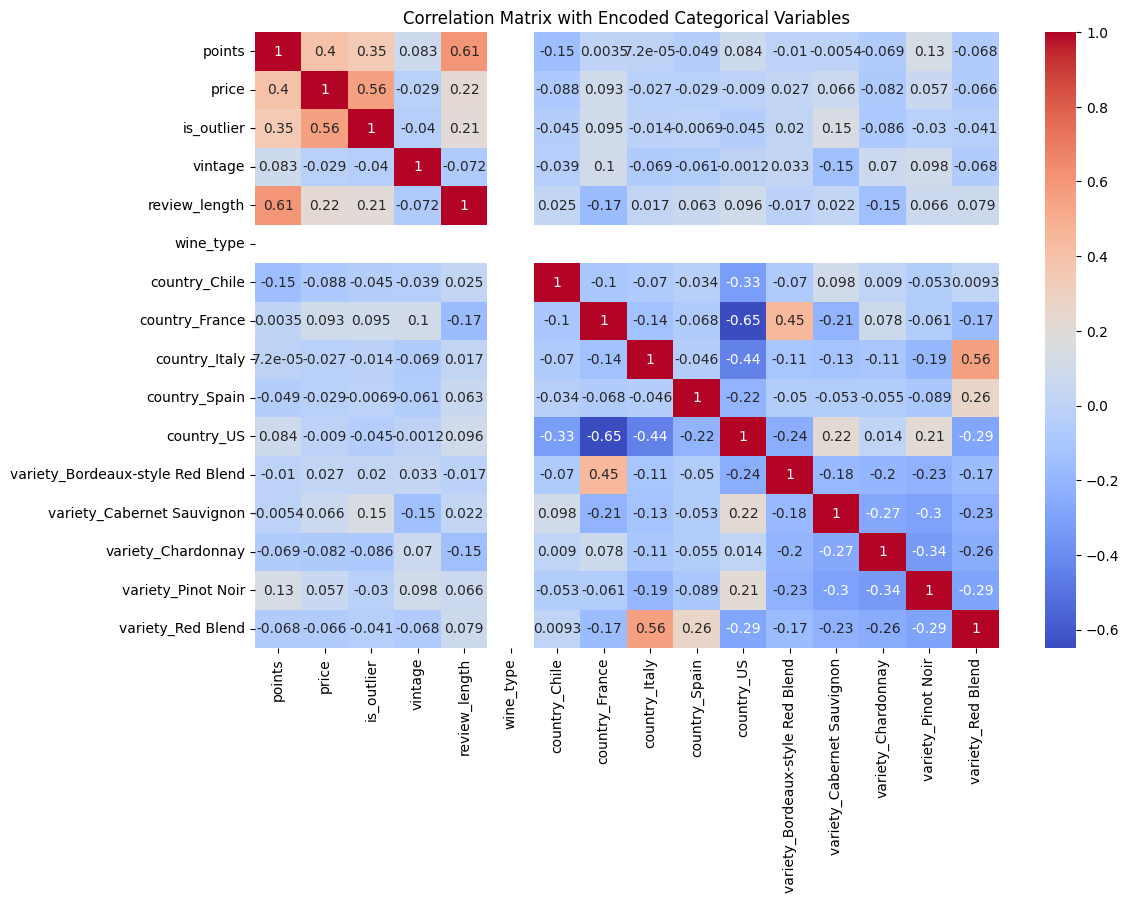

In [257]:
filtered_df = df[df['country'].isin(top_countries) & df['variety'].isin(top_varieties)]
columns_to_drop = ['description', 'designation', 'region_1', 'province', 'region_2', 'title', 'winery', 'price_category']
filtered_df = filtered_df.drop(columns=columns_to_drop)

numerical_columns = ['price', 'points']
categorical_columns = ['country', 'variety']


# Se desideri calcolare la matrice di correlazione includendo le variabili categoriche,
# potresti voler utilizzare la codifica one-hot per le variabili categoriche

# Creazione di un dataframe codificato
encoded_df = pd.get_dummies(filtered_df, columns=categorical_columns)

# Verifica delle colonne codificate e dei loro tipi di dati
print(encoded_df.columns)
print(encoded_df.dtypes)

# Assicurarsi che tutte le colonne siano numeriche
encoded_df = encoded_df.apply(pd.to_numeric, errors='coerce')

# Calcolare la matrice di correlazione per il dataframe codificato
encoded_correlation_matrix = encoded_df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(encoded_correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix with Encoded Categorical Variables')
plt.show()

## Simple Linear Regression 


predict that the country is Italy using the variety Red Blend

price = b_0 + b_1 * points


Correlation: 0.5870425366544088
P-value: 0.0
La correlazione è significativa. Possiamo rifiutare l'ipotesi nulla (correlazione = 0).
                            OLS Regression Results                            
Dep. Variable:                 points   R-squared:                       0.345
Model:                            OLS   Adj. R-squared:                  0.345
Method:                 Least Squares   F-statistic:                 5.256e+04
Date:                Fri, 31 May 2024   Prob (F-statistic):               0.00
Time:                        16:41:59   Log-Likelihood:            -2.3452e+05
No. Observations:               99952   AIC:                         4.690e+05
Df Residuals:                   99950   BIC:                         4.691e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.

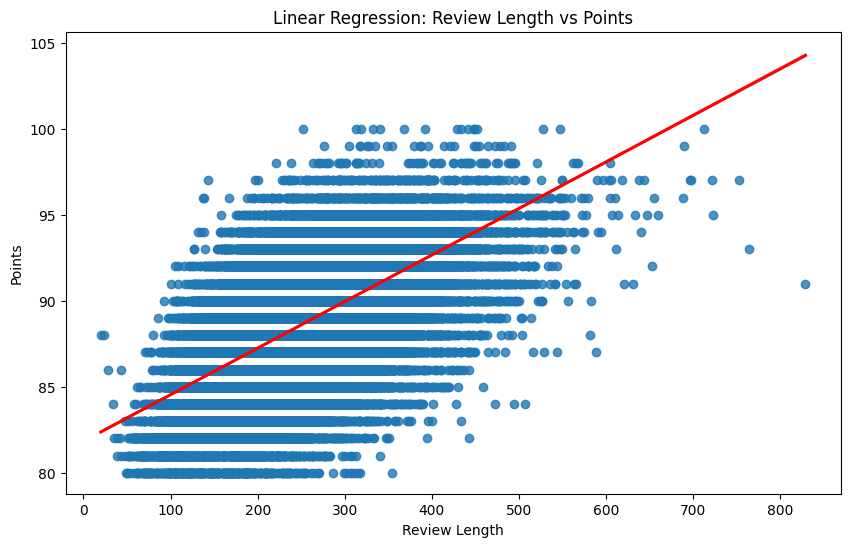

In [265]:

# Supponiamo di avere un dataframe df con le colonne 'review_length' e 'points'
# df = pd.read_csv('path_to_your_file.csv') # Carica i tuoi dati

# Calcolare la correlazione e il p-value
correlation, p_value = stats.pearsonr(df['review_length'], df['points'])
print(f"Correlation: {correlation}")
print(f"P-value: {p_value}")

# Interpretazione del test d'ipotesi
alpha = 0.05
if p_value < alpha:
    print("La correlazione è significativa. Possiamo rifiutare l'ipotesi nulla (correlazione = 0).")
else:
    print("Non possiamo rifiutare l'ipotesi nulla. La correlazione non è significativa.")

# Eseguire la regressione lineare
model = smf.ols('points ~ review_length', data=df).fit()
print(model.summary())

# Visualizzare la regressione lineare con Seaborn
plt.figure(figsize=(10, 6))
sns.regplot(x='review_length', y='points', data=df, line_kws={'color': 'red'})
plt.title('Linear Regression: Review Length vs Points')
plt.xlabel('Review Length')
plt.ylabel('Points')
plt.show()


In [259]:
y = df['points']
x1 = df['review_length']

# Calcolo delle statistiche necessarie
my = y.mean()
sy = y.std()
n = len(y)
mx1 = x1.mean()
sx1 = x1.std()

# Calcolo del coefficiente di correlazione
num1 = ((x1 - mx1) * (y - my)).sum() / (n - 1)
den1 = sx1 * sy
R_variety = num1 / den1

print("Linear correlation coefficient between Price and Points = ", R_variety)

Linear correlation coefficient between Price and Points =  0.5870425366544013


In [260]:
x_name = 'review_length'
x = df[x_name].copy()
mx = x.mean()
sx = x.std()
R = encoded_correlation_matrix.loc[x_name, 'points']
b1 = sy/sx*R
b0 = my-b1*mx
n = 42  
print(f"Points = {b0} + {b1} * Review length \nR^2 = {R**2}")

Points = 81.61503260047996 + 0.02795357452690571 * Review length 
R^2 = 0.3676031894757111


In [261]:
import statsmodels.api as sm
x = df[[x_name]].copy() # in statsmodel the intercept is modeled by adding a constant explanatory variable
x['intercept'] = 1
mod = sm.OLS(y, x) #OLS stands for ordinary least squares

fitted_mod = mod.fit()
print(fitted_mod.summary())

                            OLS Regression Results                            
Dep. Variable:                 points   R-squared:                       0.345
Model:                            OLS   Adj. R-squared:                  0.345
Method:                 Least Squares   F-statistic:                 5.256e+04
Date:                Fri, 31 May 2024   Prob (F-statistic):               0.00
Time:                        16:16:33   Log-Likelihood:            -2.3452e+05
No. Observations:               99952   AIC:                         4.690e+05
Df Residuals:                   99950   BIC:                         4.691e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
review_length     0.0271      0.000    229.252

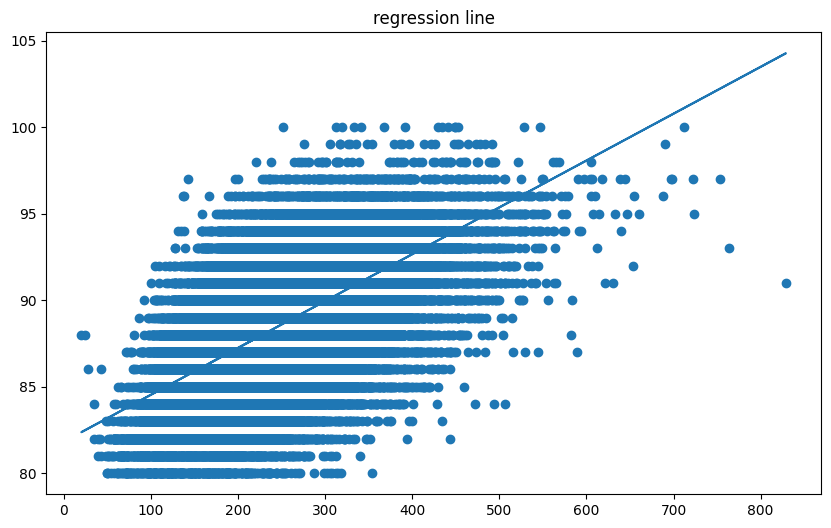

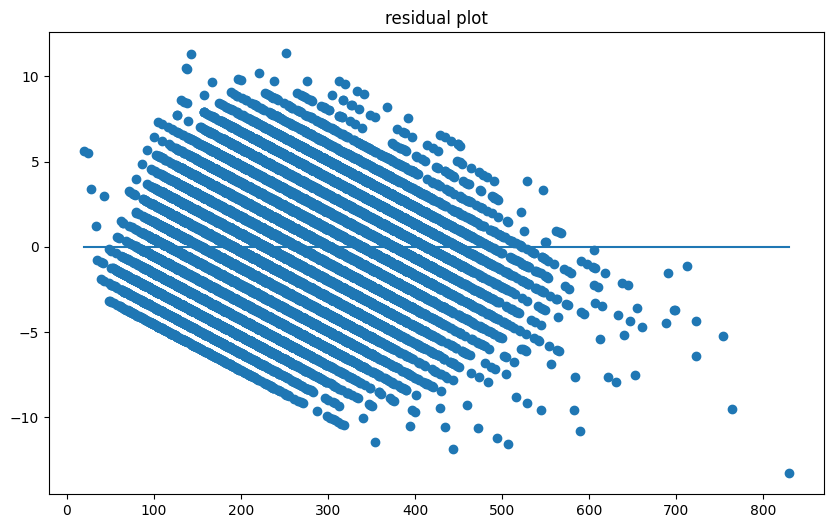

In [262]:
predictions = fitted_mod.predict(x)
plt.figure(figsize=(10, 6))
plt.scatter(x = x['review_length'],y = y)
plt.plot(x['review_length'],predictions)
plt.title('regression line')
plt.show()

residuals = y-predictions
plt.figure(figsize=(10, 6))
plt.scatter(x = x['review_length'],y = residuals)
plt.plot([x['review_length'].min(), x['review_length'].max()], [0,0])
plt.title('residual plot')
plt.show()

# Conclusions